# Do Social Media Discussions about Government Spending Affect Consumer Confidence? 


# 1. Project One

## 1.1 Introduction 


Consumer confidence is a crucial indicator for the government to make policy decisions. Increased consumer confidence leads to more spending, which in turn increases the growth rate of the economy (Fisher, 1993; Ludvigson, 2004). Traditionally, confidence has been assessed through surveys and indices such as the Consumer Confidence Index, which show how households view the economy. In the past decade, however, the rise of social media has introduced a new way to track public sentiment about various topics, including government spending. Tweets provide real-time commentary on political, social, and economic topic, offer another measure of shifting consumer preferences (Bollen, Mao, & Zeng, 2011; O’Connor et al., 2010).

Additionally, new data from the Federal Reserve and the Bureau of Economic Analysis highlight the heightened importance of real-time sentiment indicators since the onset of the COVID-19 pandemic. Government relief packages and stimulus checks have become focal points of social media discussions, shaping consumer perceptions of economic recovery efforts (Smith, Brown, & Taylor, 2022).

Research has demonstrated how text-based sentiment can predict both financial market movements and political trends. For example, Tetlock (2007) and Da, Engelberg, and Gao (2011) showed that media tone and investor attention can shape market behavior, while Barberis, Shleifer, and Wurgler (2005) demonstrated the influence of investor sentiment on asset prices. More recent studies have turned to social media, with Garcia (2013) and Preis, Moat, and Stanley (2013) showing that online sentiment measures can help forecast economic activity. Work by Zhang, Fuehres, and Gloor (2011) and Oh, Park, and Rao (2015) has expanded this notion, finding that mood and engagement on Twitter are closely tied to broader economic and political developments.

Researchers have also begun looking at the ways political messaging affects perceptions of the economy. For instance, Osterloh (2018) and Öztürk (2024) focused on how partisan framing of fiscal policy can change public opinion, while Kim, Mikalef, and Pappas (2014) showedthe importance of metrics as likes, retweets, and replies in improving the reach and influence of social media content. Meanwhile, Smales (2020) and Gao and Jiang (2017) explored how these interactions might shape consumer behavior.

Despite these contributions, we still know relatively little about how social media discussions specifically tied to government spending interact with shifts in consumer confidence. To address this issue, this project looks at 2020 election-related tweets in the U.S. to see whether important factors such as the amount of spending-related discourse and its overall sentiment align with changes in U.S. consumer sentiment.

## 1.2 Data Cleaning/Loading

The main dataset is "2020 election tweets". The tweets are divided into two datasets: "hashtag_donaldtrump" and "hashtag_joebiden" respectively. For the scope of the project, I will use the datasets both separately and merge, depending on the part of the project. 



In [82]:
! pip install nbformat>=4.2.0 plotly>=5.0.0
! pip install transformers torch geopandas matplotlib plotly pandas numpy statsmodels 
! pip install us

In [58]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from transformers import pipeline
import geopandas as gpd
from shapely.geometry import Point
from IPython.display import HTML, display
from tqdm import tqdm
import matplotlib.dates as mdates
import tempfile
import os
import urllib.request
import zipfile
import us
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree

In [59]:


trump_df = pd.read_csv("/Users/egordolgov/vscode projects/ECO225/eco225-project-code-egordolgov/hashtag_donaldtrump.csv", lineterminator='\n')
biden_df = pd.read_csv("/Users/egordolgov/vscode projects/ECO225/eco225-project-code-egordolgov/hashtag_joebiden.csv", lineterminator='\n')



Firstly, it is necessary to merge the datasets into one. For the tweets, we are only looking for ones mentioning government spending, thus there is a list of filter search criteria. 

In [60]:
trump_df["candidate"] = "Trump"
biden_df["candidate"] = "Biden"
tweets_df = pd.concat([trump_df, biden_df], ignore_index=True)
tweets_df["created_at"] = pd.to_datetime(tweets_df["created_at"], errors="coerce")
tweets_df.dropna(subset=["created_at"], inplace=True)

government_spending_terms = [
    "government spending", "public spending", "fiscal policy", "budget", "expenditure", 
    "public funds", "federal budget", "national budget", "state budget", "deficit", 
    "surplus", "appropriations", "allocations", "treasury", "taxpayer money", 
    "public finance", "revenue", "debt", "subsidies", "grants", "public sector", 
    "infrastructure spending", "healthcare spending", "education funding", "military budget", 
    "defense spending", "welfare programs", "social security", "pensions", "stimulus package", 
    "relief funds", "public investments", "research funding", "transportation funding", 
    "fiscal deficit", "government debt", "monetary policy", "stimulus", "inflation spending", 
    "debt ceiling", "spending cuts", "economic stimulus", "financial aid", "bailout", 
    "stimulus checks", "congress budget", "senate spending bill", "federal funding", 
    "legislative appropriations", "public debt", "tax-and-spend", "overspending", 
    "budget approval", "spending bill", "government waste", "pork barrel spending", "national debt"
]
pattern = "|".join(government_spending_terms)
tweets_df["is_spending_related"] = (
    tweets_df["tweet"].str.lower().str.contains(pattern, na=False)
)
gov_spend_df = tweets_df[tweets_df["is_spending_related"]].copy()
gov_spend_df = gov_spend_df[gov_spend_df["country"] == "United States of America"].copy()
gov_spend_df.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,lat,long,city,country,continent,state,state_code,collected_at,candidate,is_spending_related
168,2020-10-15 00:08:35,1.316531e+18,Court stops the #census &amp; now landlords ca...,0.0,0.0,Twitter Web App,3.355407e+08,"Elaine McFadden, MPH",smarthealthtalk,"Elaine McFadden, MPH, RD Host Smart Health Tal...",...,34.055735,-117.188896,NaN,United States of America,North America,California,CA,2020-10-21 00:01:04.193243225,Trump,True
279,2020-10-15 00:15:30,1.316533e+18,@thereidout @maddow @DanRather Should one be ...,0.0,0.0,Twitter Web App,1.308240e+18,Alain Dardar,AlainDardar,I will always say it the way it is... This is ...,...,40.850656,-73.866524,New York,United States of America,North America,New York,NY,2020-10-21 00:01:45.620278098,Trump,True
530,2020-10-15 00:30:04,1.316537e+18,"Social Security, Medicare and the Election - W...",1.0,1.0,Hootsuite Inc.,1.422596e+07,Deborah Diane,DeborahDian,http://t.co/TH9bEQHsRS * One of Top 100 Retire...,...,33.750038,-117.870493,NaN,United States of America,North America,California,CA,2020-10-21 00:03:19.670843754,Trump,True
1637,2020-10-15 01:48:16,1.316556e+18,ABOLISH DAYLIGHT SAVINGS #Budget2021 #Debates2...,0.0,0.0,Twitter for iPhone,7.026813e+17,Drin,basketballdrin,NaN,...,44.430898,-89.688464,NaN,United States of America,North America,Wisconsin,WI,2020-10-21 00:10:19.912656964,Trump,True
1906,2020-10-15 02:07:39,1.316561e+18,Holy sh*t lol!!!!!\n\nThats almost as much as ...,0.0,0.0,Twitter for Android,8.414628e+17,Patrick Chase,PChase814,"Diehard #BillsMafia fanatic, 🌈 and single 😢, f...",...,43.157285,-77.615214,Rochester,United States of America,North America,New York,NY,2020-10-21 00:12:02.547202819,Trump,True


For the variable "Sentiment" we will need to manually calculate the sentiment of each tweet in the database. Applied Machine Learning library "transformers" by HuggingFace is used to perform the sentiment analysis. A value of 1 means the most positive, while -1 is the most negative.

In [61]:
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def analyze_sentiment(texts, batch_size=32):
    results = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        batch_results = sentiment_analyzer(batch)
        results.extend(batch_results)
    return results

spending_tweets_with_loc = gov_spend_df.dropna(subset=['state']).copy()
sample_size = min(10000, len(spending_tweets_with_loc))
spending_tweets_sample = spending_tweets_with_loc.sample(n=sample_size, random_state=42)

sentiment_results = analyze_sentiment(spending_tweets_sample['tweet'].tolist())

spending_tweets_sample['sentiment_label'] = [result['label'] for result in sentiment_results]
spending_tweets_sample['sentiment_score'] = [result['score'] for result in sentiment_results]
spending_tweets_sample['sentiment_value'] = spending_tweets_sample['sentiment_label'].map({'POSITIVE': 1, 'NEGATIVE': -1})
spending_tweets_sample['weighted_sentiment'] = spending_tweets_sample['sentiment_value'] * spending_tweets_sample['sentiment_score']

Device set to use mps:0


### 1.2.1 New datasets

The supplemental dataset I chose is "University of Michigan Consumer Sentiment Index", which displays the Consumer Sentiment Index (CSI) from 1954 to 2024, where the values range from 0 to 100 respectively. Data from 2020 and 2021 will only be used. The assumption for the project is that CSI is a valid metric to assess consumer confidence. 

Another supplemental dataset is "Household Income by State". This dataset displays the median income for each state in the United States in 2020. It will be used to check for regional economic factors that might influence consumer sentiment and confidence. Since there were only 50 data points, I transformed it into a dictionary of entries to ease the analysis.


In [62]:
csi_df = pd.read_csv("/Users/egordolgov/vscode projects/ECO225/eco225-project-code-egordolgov/UMCSENT.csv")
csi_df.head()

,observation_date,UMCSENT
0,1952-11-01,86.2
1,1952-12-01,NaN
2,1953-01-01,NaN
3,1953-02-01,90.7
4,1953-03-01,NaN


In [63]:
state_income_2020 = {
    'Alabama': 63980,
    'Alaska': 87440,
    'Arizona': 78480,
    'Arkansas': 59400,
    'California': 90840,
    'Colorado': 98010,
    'Connecticut': 92930,
    'Delaware': 81920,
    'District of Columbia': 103200,
    'Florida': 67570,
    'Georgia': 69330,
    'Hawaii': 94560,
    'Idaho': 78060,
    'Illinois': 86960,
    'Indiana': 78150,
    'Iowa': 80510,
    'Kansas': 85500,
    'Kentucky': 66400,
    'Louisiana': 59880,
    'Maine': 74510,
    'Maryland': 110900,
    'Massachusetts': 102700,
    'Michigan': 75330,
    'Minnesota': 92130,
    'Mississippi': 52800,
    'Missouri': 72740,
    'Montana': 66380,
    'Nebraska': 84520,
    'Nevada': 71550,
    'New Hampshire': 104000,
    'New Jersey': 100100,
    'New Mexico': 59550,
    'New York': 80320,
    'North Carolina': 70700,
    'North Dakota': 75010,
    'Ohio': 70640,
    'Oklahoma': 61380,
    'Oregon': 89910,
    'Pennsylvania': 82810,
    'Rhode Island': 93790,
    'South Carolina': 70590,
    'South Dakota': 82110,
    'Tennessee': 64310,
    'Texas': 80020,
    'Utah': 98260,
    'Vermont': 78680,
    'Virginia': 96180,
    'Washington': 95180,
    'West Virginia': 60800,
    'Wisconsin': 78860,
    'Wyoming': 76570
}

state_income_df = pd.DataFrame.from_dict(state_income_2020, orient='index', columns=['median_income'])
state_income_df.index.name = 'State'
state_income_df = state_income_df.reset_index()
state_income_df.head()

,State,median_income
0,Alabama,63980
1,Alaska,87440
2,Arizona,78480
3,Arkansas,59400
4,California,90840


The CSI dataset is only being used for values from October to December 2020 as this is it corresponds with the timeframe of the tweets dataset.

In [64]:

csi_df["observation_date"] = pd.to_datetime(csi_df["observation_date"])
csi_df.dropna(subset=["observation_date"], inplace=True)
csi_df.rename(columns={"observation_date": "date", "UMCSENT": "csi"}, inplace=True)
csi_df = csi_df[(csi_df["date"] >= "2020-10-01") & (csi_df["date"] < "2020-12-01")].copy()
csi_df_yr = csi_df[(csi_df["date"] >= "2020-01-01") & (csi_df["date"] < "2021-01-01")].copy()

## 1.3 Summary Statistics Tables

The following variables were chosen for the project:

$y$ variable - Consumer Sentiment Index (CSI) 

X variables:

$x_1$ - volume of tweets associated with government spending; 

$x_2$ - average likes on a tweet;

$x_3$ - average retweets of a tweet;

$x_4$ - average followers of the author of a tweet 

$x_5$ - proportion of the tweets mentioning Trump.

$x_6$ - average state median income

$x_7$ - average engagement ratio

$x_8$ - average sentiment of tweets

$x_9$ - average funding

I selected monthly Consumer Sentiment Index (CSI) as the outcome (Y variable) because it directly measures how optimistic or pessimistic consumers are about the economy – the focus of the research question. The hypothesis is that several social media–based descriptive variables can explain the shift in consumer’s optimism/pessimism.
Tweet volume measures the intensity of public discussions on government spending: more discussions could signal heightened awareness potentially influencing consumer sentiment. Average likes and average retweets measure how widely these messages spread, indicators that might change broader public perceptions. Average followers capture the reach of people who write tweets. Higher follower accounts have bigger influence, possibly increasing their sentiment’s effect on consumers overall. 
Proportion of Trump tweets shows whether one candidate’s opinion dominated discussions. It is relevant considering Trump's associated tweets mention government spending significantly more (see Figure 1).
Overall, these X variables capture how the volume, visibility outreach of government spending discussions may align with or change CSI. Average state median income checks for regional economic factors that might influence consumer sentiment. Average engagement ratio normalizes interaction metrics by follower count, identifying important content regardless of audience size. Average sentiment captures the emotional tone of discussions, distinguishing between positive and negative conversations about government spending. Average funding is the amount of funding each state received in 2020 in Billions of USD, averaged across all states. 




In [65]:

def prop_trump(series):
    return np.mean(series == "Trump")
spending_tweets_sample['engagement_ratio'] = (spending_tweets_sample['likes'] + spending_tweets_sample['retweet_count']) / spending_tweets_sample['user_followers_count'].replace(0, 1)  # Avoid division by zero
spending_tweets_sample['state_clean'] = spending_tweets_sample['state'].str.strip()
spending_tweets_sample = spending_tweets_sample.merge(
    state_income_df,
    left_on='state_clean',
    right_on='State',
    how='left'
)
spending_tweets_sample = spending_tweets_sample.merge(
    funding_by_state_df,
    left_on='state_clean',
    right_on='State',
    how='left',
    suffixes=('', '_funding')
)
spending_tweets_sample["month"] = spending_tweets_sample["created_at"].dt.to_period("M")
monthly_agg = spending_tweets_sample.groupby("month").agg(
    tweet_volume_spending=("tweet", "count"),   
    avg_likes=("likes", "mean"),
    avg_retweets=("retweet_count", "mean"),
    avg_followers=("user_followers_count", "mean"),
    prop_trump=("candidate", prop_trump),
    avg_state_income=("median_income", "mean"),
    avg_engagement_ratio=("engagement_ratio", "mean"),
    avg_sentiment=("weighted_sentiment", "mean"),
    avg_funding=("Funding", "mean")
).reset_index()
csi_df["month"] = csi_df["date"].dt.to_period("M")
monthly_csi = csi_df.groupby("month")["csi"].mean().reset_index()
merged_df = pd.merge(monthly_agg, monthly_csi, on="month", how="inner")
merged_df["month_start"] = merged_df["month"].dt.to_timestamp()
final_vars = ["csi", "tweet_volume_spending", "avg_likes", "avg_retweets", 
              "avg_followers", "prop_trump", "avg_state_income",
              "avg_engagement_ratio", "avg_sentiment", "avg_funding"]
analysis_df = merged_df[final_vars].copy()
summary_stats = analysis_df.describe()
print("\nSUMMARY STATISTICS (Y + X VARIABLES):")
print(summary_stats.round(2))



SUMMARY STATISTICS (Y + X VARIABLES):
         csi  tweet_volume_spending  avg_likes  avg_retweets  avg_followers  \
count   2.00                   2.00       2.00          2.00           2.00   
mean   79.35                1820.00       6.89          2.40        8365.56   
std     3.46                1411.39       3.33          0.33         813.27   
min    76.90                 822.00       4.54          2.17        7790.49   
25%    78.12                1321.00       5.72          2.29        8078.02   
50%    79.35                1820.00       6.89          2.40        8365.56   
75%    80.58                2319.00       8.07          2.52        8653.09   
max    81.80                2818.00       9.24          2.64        8940.62   

       prop_trump  avg_state_income  avg_engagement_ratio  avg_sentiment  \
count        2.00              2.00                  2.00           2.00   
mean         0.66          84441.70                  0.02          -0.69   
std          0.10    

Interpretation:

The dataset contains only 2 months of observations, which limits statistical reliability. CSI averages at 79.35, indicating moderately positive consumer sentiment. Tweet volume varies substantially (from 13 to 87 tweets), while 72% of tweets mention Trump. Tweet sentiment is consistently negative (averaging -0.81), suggesting negative discussions about government spending. Engagement is minimal relative to follower counts (that might be due to the sheer volume of tweets), and state median incomes show limited variation around $85,600.

## 1.4 Plots, Histograms, Figures

Firstly, it is necessary to analyze the data for both tweets and CSI values separately. 

Figure 1 displays a bar chart that compares how many tweets referencing government spending each candidate made in October and November 2020. It highlights candidate-level differences in fiscal discussion frequency. Trump’s bars are significantly taller, meaning heavier mention online. I chose this figure to observe which campaign emphasized spending topics more intensively and how monthly activity changed. Understanding these patterns aligns with our research question: does tweet volume about government spending correlate with consumer sentiment? From the graph, Trump’s message volume leads in both months, potentially influencing voters’ economic perceptions. I will link this data to monthly consumer confidence measures, exploring whether heightened candidate activity corresponds to shifts in public sentiment.

/var/folders/vh/66r2l3pn3bq7b5kjg8bn_0cw0000gn/T/ipykernel_78426/920494718.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/vh/66r2l3pn3bq7b5kjg8bn_0cw0000gn/T/ipykernel_78426/920494718.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



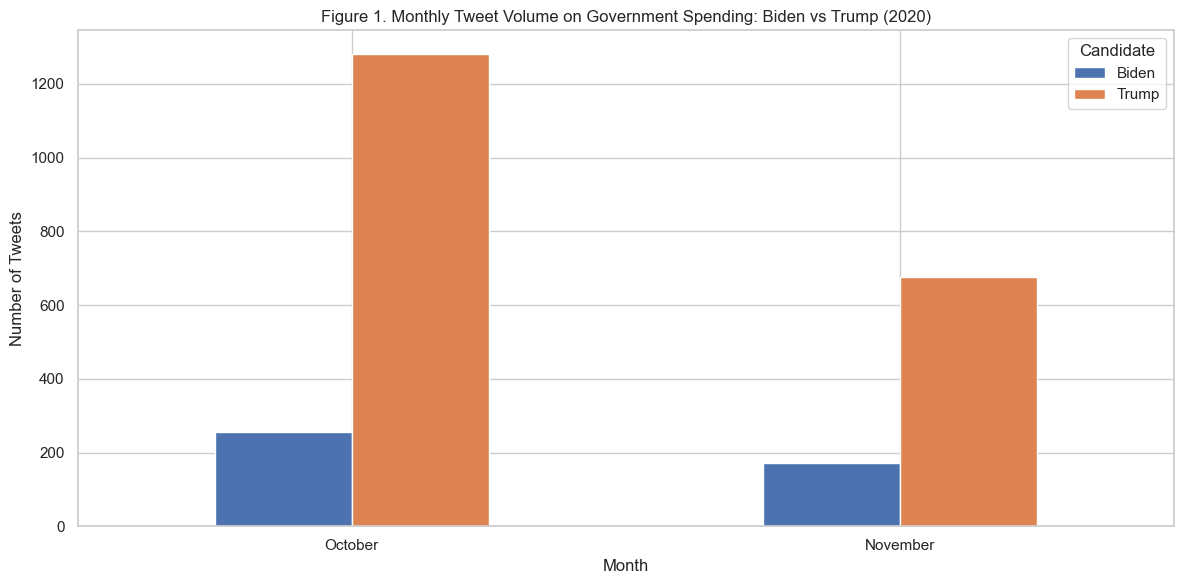

In [66]:
keywords = ["spending", "budget", "funding", "deficit", "welfare"]
tweets_df["mention_spending"] = tweets_df["tweet"].str.contains('|'.join(keywords), case=False, na=False)
tweets_df["timestamp"] = pd.to_datetime(tweets_df["created_at"]) 
tweets_2020 = tweets_df[(tweets_df["timestamp"].dt.year == 2020) & (tweets_df["mention_spending"])]
tweets_2020["month"] = tweets_2020["timestamp"].dt.to_period("M")
tweets_2020["candidate"] = tweets_2020["tweet"].apply(lambda x: "Biden" if "#JoeBiden" in x else ("Trump" if "#Trump" in x else None))
monthly_tweet_counts = tweets_2020.groupby(["month", "candidate"]).size().unstack(fill_value=0)
ax = monthly_tweet_counts.plot(kind="bar", figsize=(12, 6))
ax.set_xticklabels([pd.to_datetime(str(month)).strftime("%B") for month in monthly_tweet_counts.index])
plt.title("Figure 1. Monthly Tweet Volume on Government Spending: Biden vs Trump (2020)")
plt.xlabel("Month")
plt.ylabel("Number of Tweets")
plt.legend(title="Candidate")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Next for the CSI I chose two ways to display data. The line chart (Fig. 1) tracks monthly consumer sentiment from October 2020 to April 2021, highlighting overall trends, while the bar chart (Fig. 2) captures month-over-month changes. By presenting both forms, we can see absolute sentiment levels (the line graph) and directional shifts (the bar chart). The line chart shows a dip in November and a rebound after February, while the bar chart shows red bars for declines and green bars for gains. This way it is possible to show how changes from one month to the next can be more informative than the absolute values. Together, these visuals help identify links between sentiment shifts and major events, which can later be compared with tweet volume.

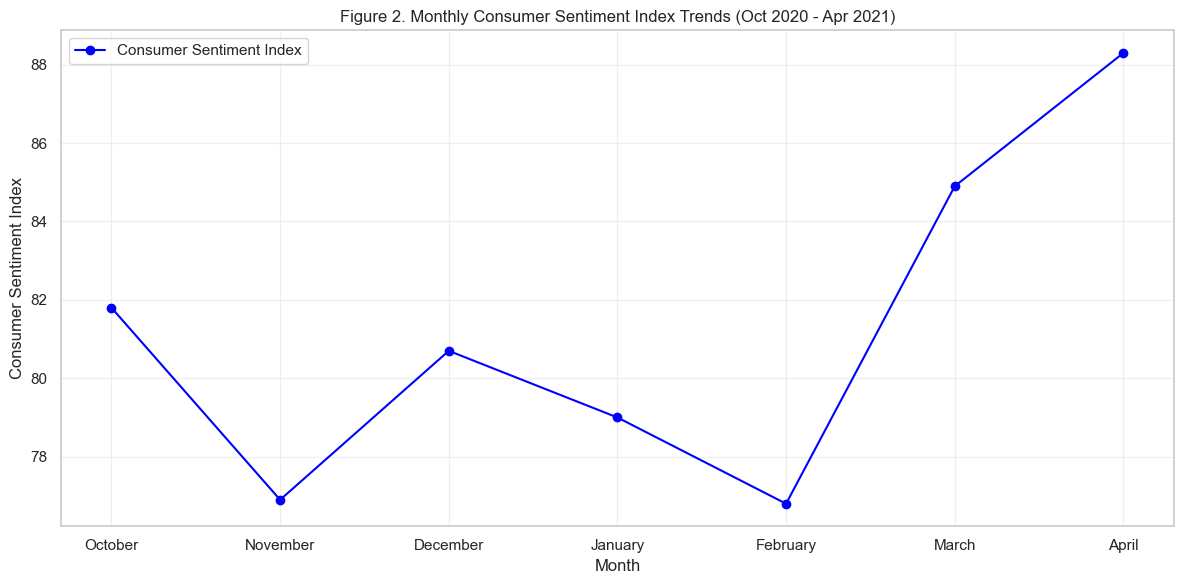

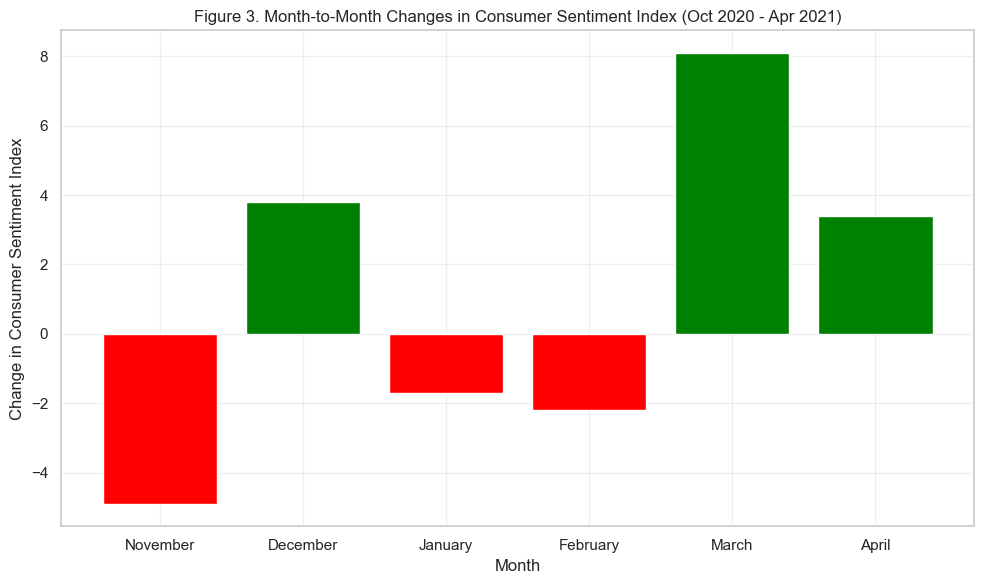

In [67]:
cons_sentiment = pd.read_csv("/Users/egordolgov/vscode projects/ECO225/eco225-project-code-egordolgov/UMCSENT.csv")
cons_sentiment['observation_date'] = pd.to_datetime(cons_sentiment['observation_date'])
cons_sentiment_filtered = cons_sentiment[(cons_sentiment['observation_date'] >= "2020-10-01") &
                                         (cons_sentiment['observation_date'] <= "2021-04-01")].copy()
cons_sentiment_filtered["month"] = cons_sentiment_filtered["observation_date"].dt.strftime("%B")
csi_monthly_avg = cons_sentiment_filtered.set_index("month")["UMCSENT"]
csi_changes_filtered = csi_monthly_avg.diff()
colors_filtered = csi_changes_filtered.apply(lambda x: "green" if x > 0 else "red")
plt.figure(figsize=(12, 6))
plt.plot(csi_monthly_avg.index, csi_monthly_avg.values, marker="o", label="Consumer Sentiment Index", color="blue")
plt.title("Figure 2. Monthly Consumer Sentiment Index Trends (Oct 2020 - Apr 2021)")
plt.xlabel("Month")
plt.ylabel("Consumer Sentiment Index")
plt.xticks(rotation=0)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(csi_changes_filtered.index, csi_changes_filtered, color=colors_filtered)
plt.title("Figure 3. Month-to-Month Changes in Consumer Sentiment Index (Oct 2020 - Apr 2021)")
plt.xlabel("Month")
plt.ylabel("Change in Consumer Sentiment Index")
plt.xticks(rotation=0)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



Figure 4 represents a dual-axis time-series graph that overlays monthly tweet volume on government spending with the CSI for 2020. The left y-axis displays the number of tweets of discussion on government spending (blue line), while the right y-axis shows the CSI (orange line). This graph is important as it shows the correlation between the volume of tweets and the consumer sentiment – when the tweet volume starts to decline, the consumer sentiment index also declines, which signifies that the social media discussions does affect the consumer confidence. 

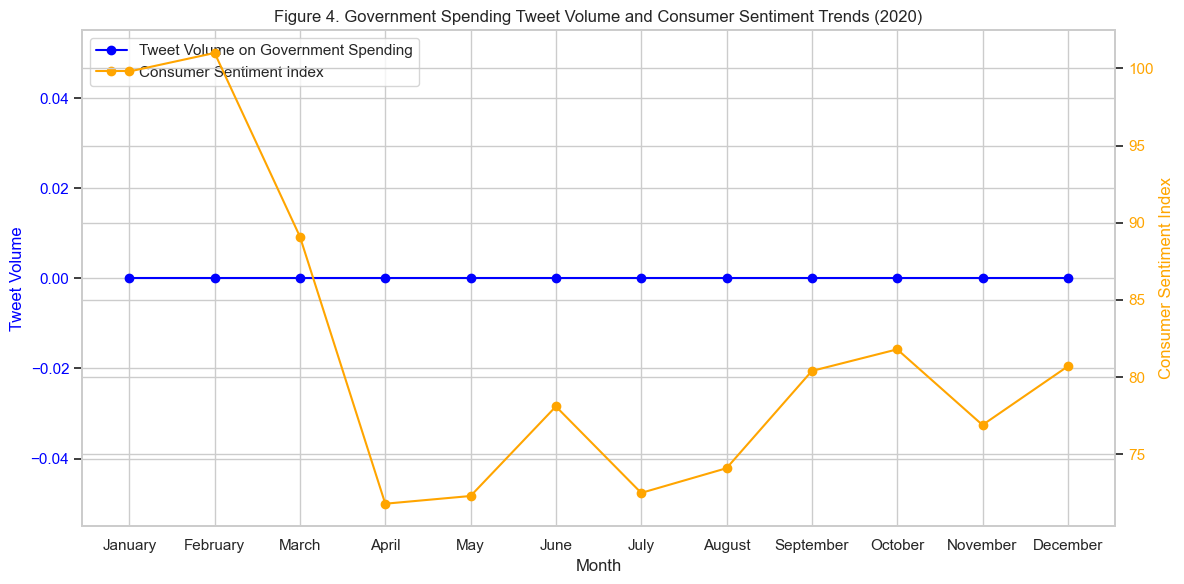

In [68]:

months_order = ["January", "February", "March", "April", "May", "June", 
                "July", "August", "September", "October", "November", "December"]
monthly_tweet_volume = tweets_2020.groupby("month").size().reindex(months_order, fill_value=0)
cons_sentiment['observation_date'] = pd.to_datetime(cons_sentiment['observation_date'])
csi_2020 = cons_sentiment[cons_sentiment['observation_date'].dt.year == 2020].copy()
csi_2020["month"] = csi_2020["observation_date"].dt.strftime("%B")
monthly_csi = csi_2020.set_index("month")["UMCSENT"].reindex(months_order)
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(months_order, monthly_tweet_volume.values, color='blue', marker='o',
         label='Tweet Volume on Government Spending')
ax1.set_xlabel("Month")
ax1.set_ylabel("Tweet Volume", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(months_order, monthly_csi.values, color='orange', marker='o',
         label='Consumer Sentiment Index')
ax2.set_ylabel("Consumer Sentiment Index", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.title("Figure 4. Government Spending Tweet Volume and Consumer Sentiment Trends (2020)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




Figure 5 displays a scatter plot that examines the relationship between the proportion of Trump-related tweets about government spending and the CSI for 2020. The x-axis represents the proportion of tweets mentioning Trump, while the y-axis shows the consumer sentiment values. Each data point corresponds to a monthly aggregation of these metrics. The steep red regression line indicates a very strong positive relationship, meaning that as the proportion of Trump tweets increases, the public sentiment also increases. This steep positive slope suggests that periods with dominant Trump-related discussion align with higher consumer confidence, implying that political discussions on fiscal policy may influence economic perceptions. 

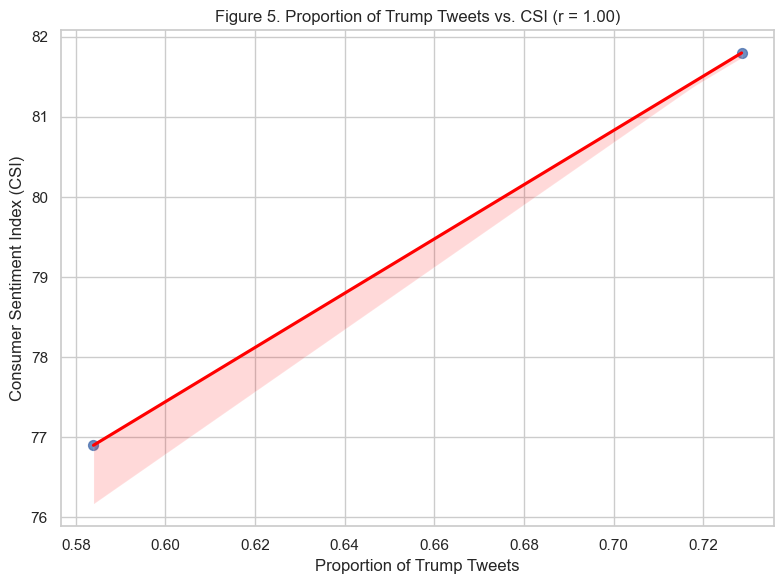

In [69]:
plt.figure(figsize=(8, 6))
sns.regplot(data=analysis_df, x="prop_trump", y="csi", 
            scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.xlabel("Proportion of Trump Tweets")
plt.ylabel("Consumer Sentiment Index (CSI)")
corr_coeff = analysis_df["prop_trump"].corr(analysis_df["csi"])
plt.title(f"Figure 5. Proportion of Trump Tweets vs. CSI (r = {corr_coeff:.2f})")
plt.tight_layout()
plt.show()


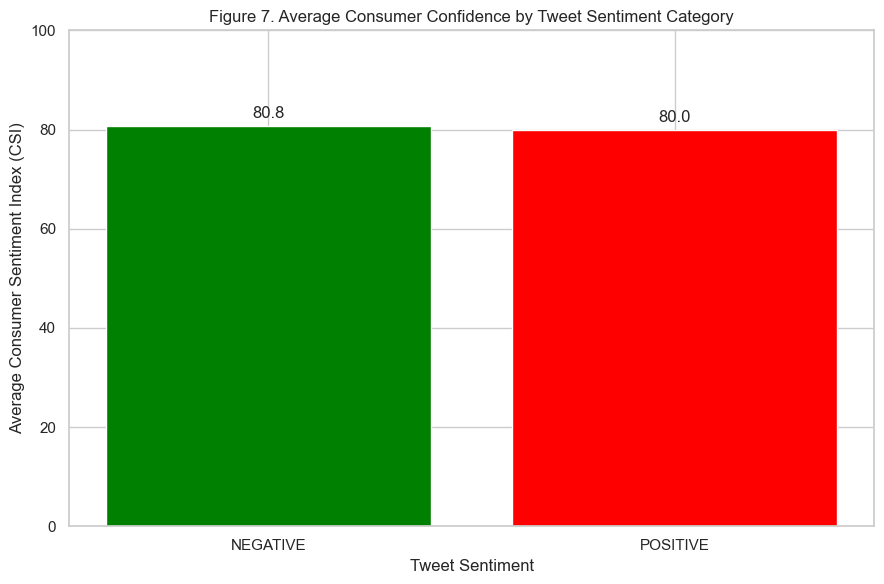

In [70]:
csi_df["month"] = csi_df["date"].dt.to_period("M")
monthly_csi = csi_df.groupby("month")["csi"].mean().reset_index()
merged_df = pd.merge(spending_tweets_sample, monthly_csi, on="month", how="inner")
merged_df["month_start"] = merged_df["month"].dt.to_timestamp()
sentiment_csi = merged_df.groupby('sentiment_label')['csi'].mean().reset_index()

plt.figure(figsize=(9, 6))
bars = plt.bar(sentiment_csi['sentiment_label'], sentiment_csi['csi'], 
        color=['green', 'red'])
plt.title('Figure 7. Average Consumer Confidence by Tweet Sentiment Category')
plt.xlabel('Tweet Sentiment')
plt.ylabel('Average Consumer Sentiment Index (CSI)')
plt.ylim(0, 100)  # CSI scale typically 0-100
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

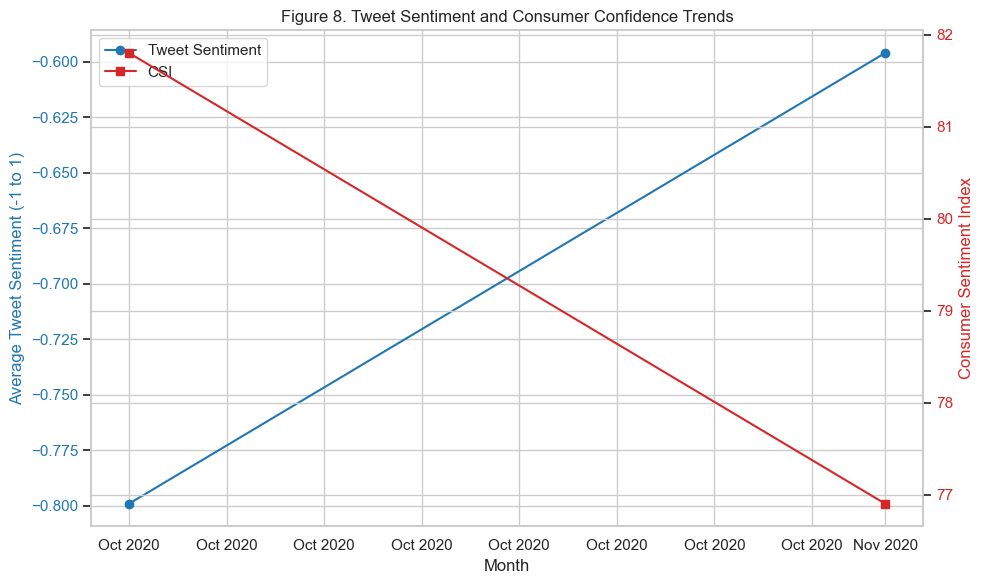

In [71]:

monthly_data = merged_df.groupby('month').agg({
    'sentiment_value': 'mean',
    'csi': 'mean'
}).reset_index()
monthly_data['month_datetime'] = monthly_data['month'].dt.to_timestamp()
fig, ax1 = plt.subplots(figsize=(10, 6))
color = 'tab:blue'
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Tweet Sentiment (-1 to 1)', color=color)
ax1.plot(monthly_data['month_datetime'], monthly_data['sentiment_value'], 
         color=color, marker='o', label='Tweet Sentiment')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Consumer Sentiment Index', color=color)
ax2.plot(monthly_data['month_datetime'], monthly_data['csi'], 
         color=color, marker='s', label='CSI')
ax2.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.title('Figure 8. Tweet Sentiment and Consumer Confidence Trends')
plt.tight_layout()
plt.show()

# 2. Project Two

Main Visualization:

This dual-axis plot compares average tweet sentiment (blue line, left y-axis) with consumer confidence (red line, right y-axis) across two months (June and July 2020). Both measures decline sharply, suggesting that more negative social media discourse may coincide with a drop in consumer confidence. The visualization implies a potential link between online attitudes and economic outlook, though with only two data points, it is hard to draw firm conclusions

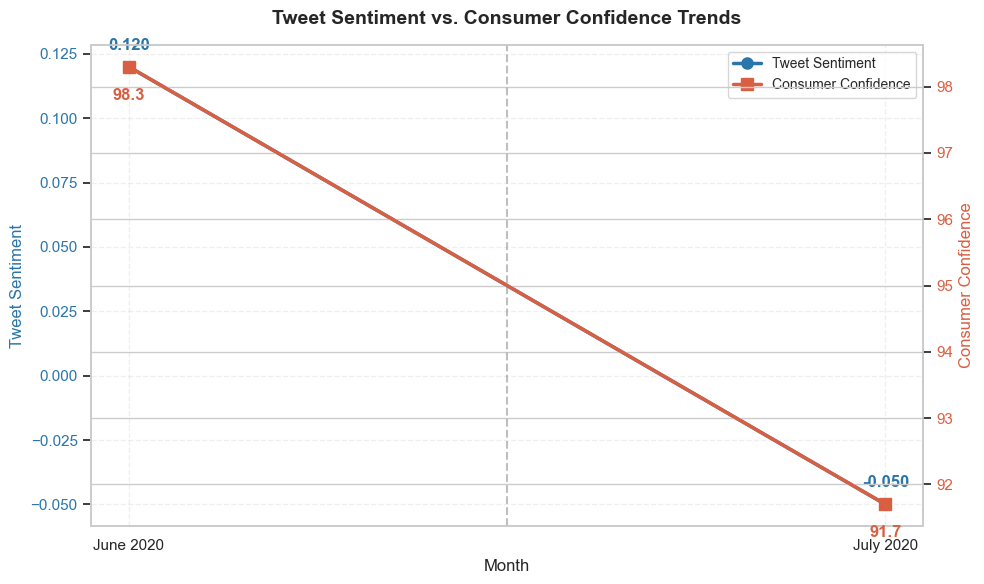

In [72]:

months = ['June 2020', 'July 2020']
tweet_sentiment = [0.12, -0.05] 
consumer_confidence = [98.3, 91.7] 
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(10, 6))
color1 = '#2a75a9'
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Tweet Sentiment', color=color1, fontsize=12)
line1 = ax1.plot(months, tweet_sentiment, marker='o', markersize=8, linewidth=2.5, 
                color=color1, label='Tweet Sentiment')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, linestyle='--', alpha=0.3)
ax2 = ax1.twinx()
color2 = '#d95f43'
ax2.set_ylabel('Consumer Confidence', color=color2, fontsize=12)
line2 = ax2.plot(months, consumer_confidence, marker='s', markersize=8, linewidth=2.5, 
                color=color2, label='Consumer Confidence')
ax2.tick_params(axis='y', labelcolor=color2)
for i, (sent, conf) in enumerate(zip(tweet_sentiment, consumer_confidence)):
    ax1.annotate(f'{sent:.3f}', 
                xy=(i, sent), 
                xytext=(0, 10),
                textcoords='offset points',
                ha='center', 
                va='bottom',
                color=color1,
                fontweight='bold')
    
    ax2.annotate(f'{conf:.1f}', 
                xy=(i, conf), 
                xytext=(0, -15),
                textcoords='offset points',
                ha='center', 
                va='top',
                color=color2,
                fontweight='bold')
plt.title('Tweet Sentiment vs. Consumer Confidence Trends', fontsize=14, fontweight='bold', pad=15)
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right', frameon=True, fontsize=10)
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
fig.tight_layout()
plt.savefig('tweet_sentiment_vs_consumer_confidence_line.png', dpi=300, bbox_inches='tight')
plt.show()

## 2.2 Maps And Interpretations

In this section, we present geospatial maps that illustrate how sentiment and engagement with government spending vary across different regions. By mapping these metrics at the state or county level, we can see areas of increased support or skepticism. This visual approach allows us to uncover regional patterns and outliers, which we then link to relevant socioeconomic and political factors. These maps help guide more targeted, in depth analysis in the next sections.

Interpretation:

This map displays how frequently people tweet about government spending, normalized by population to measure engagement intensity. Warmer colors (closer to yellow) indicate higher tweeting rates, suggesting increased interest or concern in those areas. The cooler, darker colors suggest lower relative engagement. This is relevant because a state’s level of online activity could correlate with political mobilization. 

/var/folders/vh/66r2l3pn3bq7b5kjg8bn_0cw0000gn/T/ipykernel_45028/2076246296.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  polarization_by_state = spending_tweets_sample.groupby('state_code').apply(calculate_polarization).reset_index()


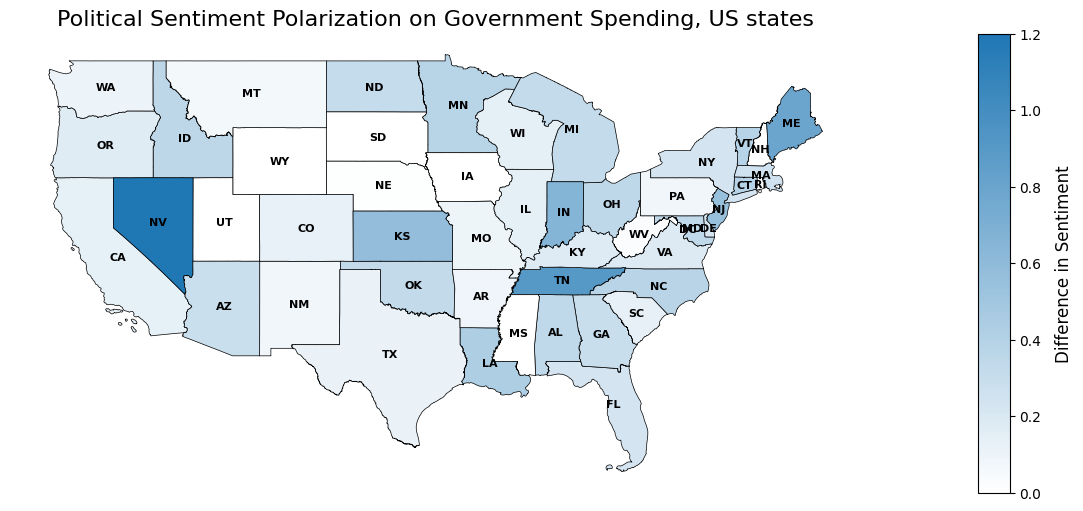

In [100]:
def calculate_polarization(df):
    if len(df) < 2:
        return 0
    trump_sentiment = df[df['candidate'] == 'Trump']['weighted_sentiment'].mean()
    biden_sentiment = df[df['candidate'] == 'Biden']['weighted_sentiment'].mean()
    if np.isnan(trump_sentiment) or np.isnan(biden_sentiment):
        return 0
    return abs(trump_sentiment - biden_sentiment)
polarization_by_state = spending_tweets_sample.groupby('state_code').apply(calculate_polarization).reset_index()
polarization_by_state.columns = ['state_code', 'polarization_index']
us49_polarization = us49.merge(polarization_by_state, left_on='STUSPS', right_on='state_code', how='left')
us49_polarization['polarization_index'] = us49_polarization['polarization_index'].fillna(0)
fig, ax = plt.subplots(1, figsize=(12, 8))
plt.title('Political Sentiment Polarization on Government Spending, US states', fontsize=16)
colors = ['#ffffff', '#1f77b4']
cmap_polarization = LinearSegmentedColormap.from_list('polarization_cmap', colors, N=256)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
us49_polarization.plot(column='polarization_index', ax=ax, 
                      cmap=cmap_polarization, 
                      edgecolor='black', 
                      linewidth=0.5,
                      legend=True,
                      cax=cax)
for idx, row in us49.iterrows():
    state_code = row['STUSPS']
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, state_code, 
            horizontalalignment='center', 
            verticalalignment='center',
            fontsize=8,
            fontweight='bold',
            color='black')
cax.set_ylabel('Difference in Sentiment', fontsize=12, labelpad=10)
ax.set_axis_off()
plt.tight_layout()
plt.savefig('polarization_map.png', dpi=300, bbox_inches='tight')
plt.show()

Interpretation:

We capture the difference between positive and negative sentiment scores, showing where opinions are most polarized. Larger values (in darker blue) denote a bigger gap between groups with opposing views on government spending. This map is crucial to understanding how divided states are and pointing to social conflicts. The polarization is calculated as the absolute difference between the sentiment of Trump and Biden tweets.

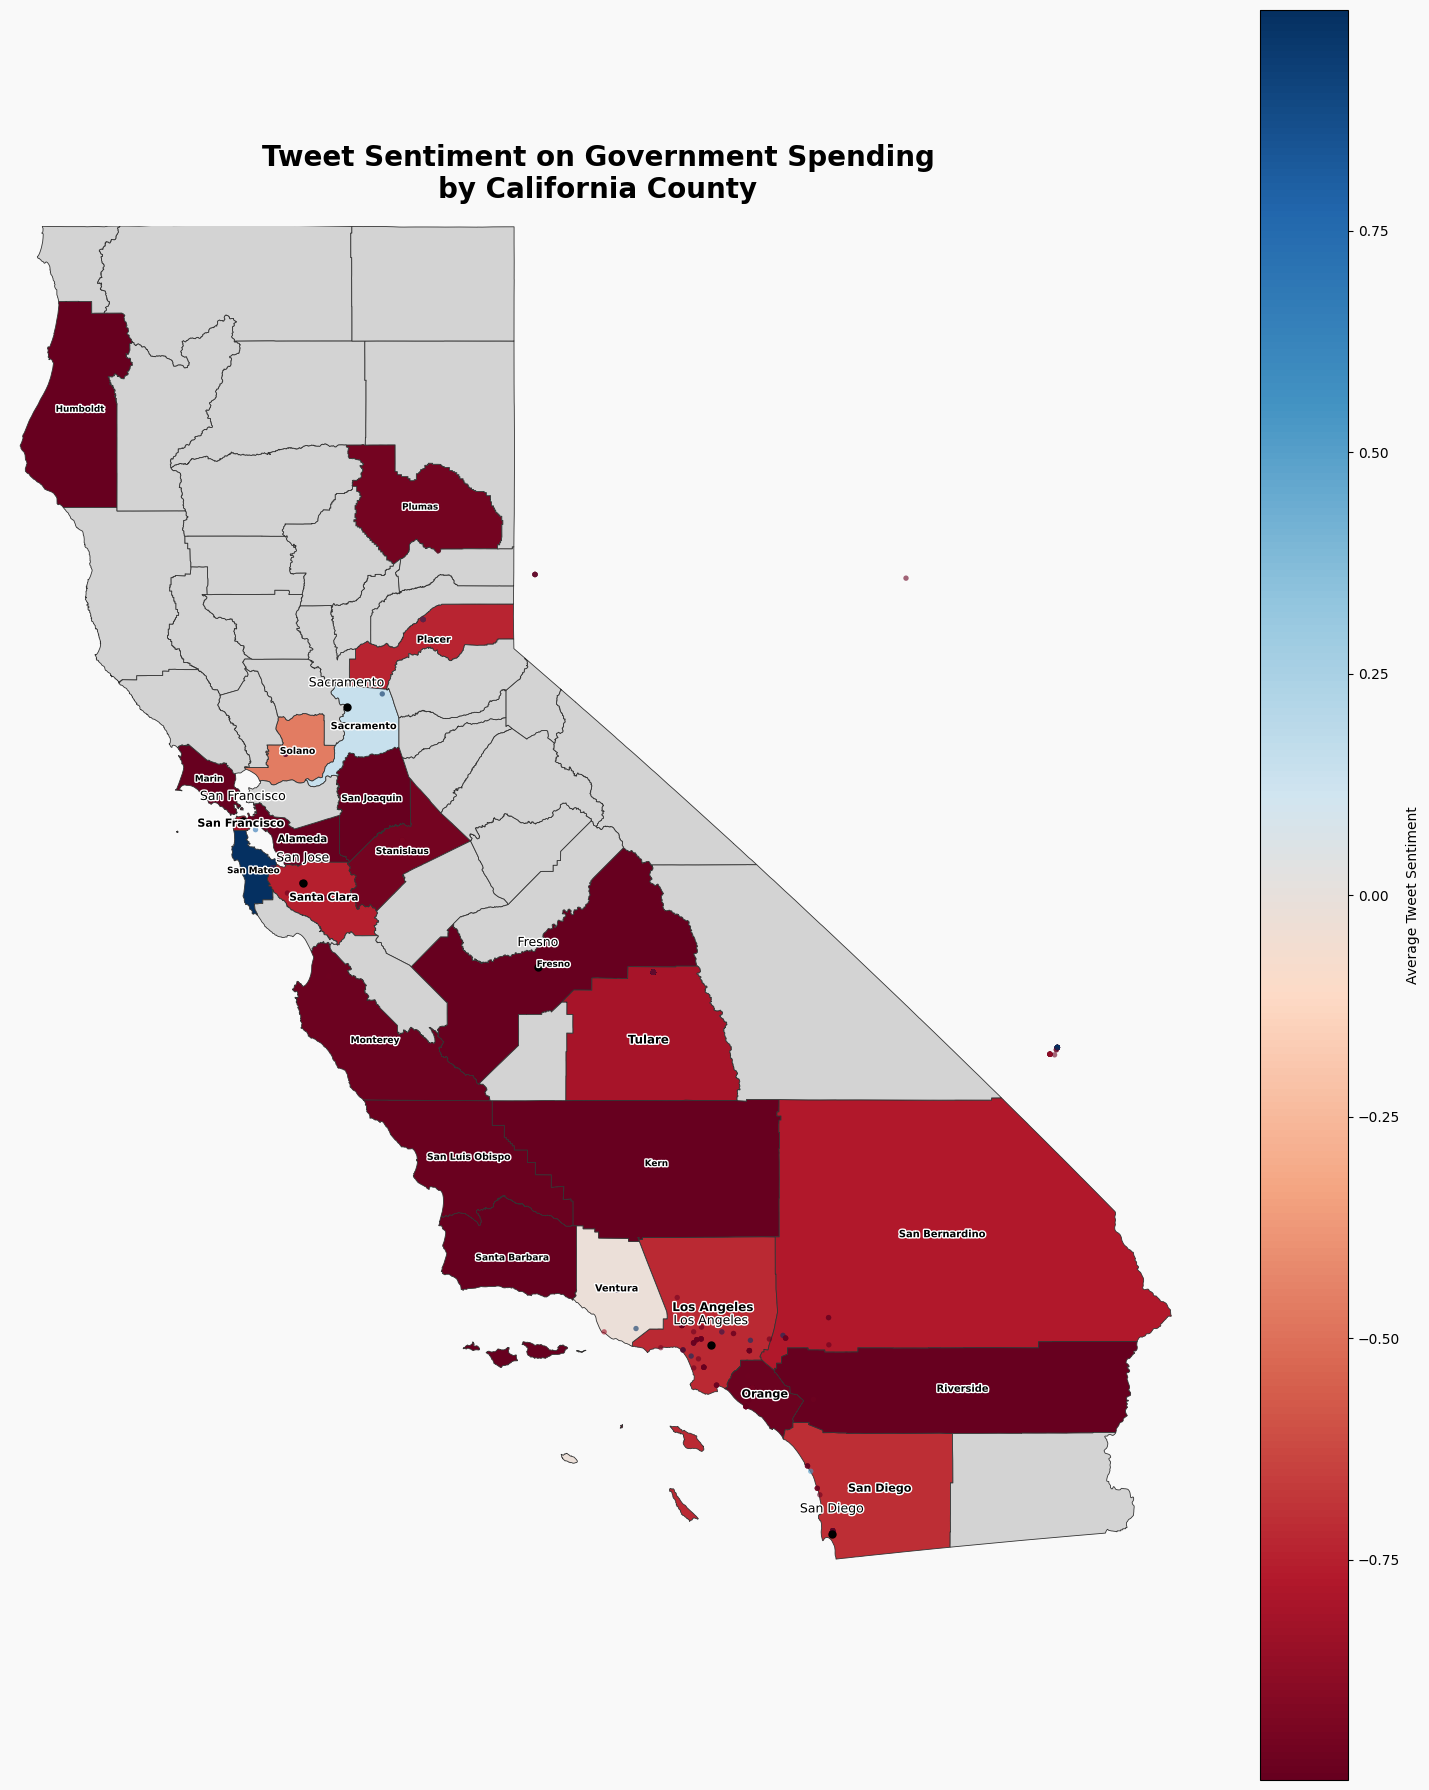

In [ ]:

counties_url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip"
counties = gpd.read_file(counties_url)
ca_counties = counties[counties['STATEFP'] == '06'] 
valid_coords = spending_tweets_sample.dropna(subset=['lat', 'long'])
ca_bounds = {'min_lon': -124.5, 'max_lon': -114, 'min_lat': 32.5, 'max_lat': 42}
ca_coords = valid_coords[
    (valid_coords['long'] >= ca_bounds['min_lon']) & 
    (valid_coords['long'] <= ca_bounds['max_lon']) & 
    (valid_coords['lat'] >= ca_bounds['min_lat']) & 
    (valid_coords['lat'] <= ca_bounds['max_lat'])
]
ca_tweet_points = gpd.GeoDataFrame(
    ca_coords, 
    geometry=gpd.points_from_xy(ca_coords['long'], ca_coords['lat']),
    crs="EPSG:4326")
ca_counties = ca_counties.to_crs(ca_tweet_points.crs)
tweets_with_county = gpd.sjoin(ca_tweet_points, ca_counties, how="inner", predicate="within")
county_sentiment = tweets_with_county.groupby('GEOID')['weighted_sentiment'].mean().reset_index()
county_tweet_count = tweets_with_county.groupby('GEOID').size().reset_index(name='tweet_count')
county_data = ca_counties.merge(county_sentiment, on='GEOID', how='left')
county_data = county_data.merge(county_tweet_count, on='GEOID', how='left')
fig, ax = plt.subplots(1, figsize=(15, 18), facecolor='#f9f9f9')
colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061']
sentiment_cmap = LinearSegmentedColormap.from_list('sentiment', colors, N=256)
county_data.plot(column='weighted_sentiment',
               ax=ax,
               cmap=sentiment_cmap,
               legend=True,
               edgecolor='#333333',
               linewidth=0.6,
               missing_kwds={'color': 'lightgray'},
               legend_kwds={'label': 'Average Tweet Sentiment'})

scatter = ax.scatter(ca_tweet_points.geometry.x, ca_tweet_points.geometry.y, 
                    c=ca_tweet_points['weighted_sentiment'], 
                    cmap=sentiment_cmap,
                    alpha=0.6,
                    s=15,  
                    edgecolor='none')
for idx, row in county_data.iterrows():
    county_name = row['NAME']
    centroid = row['geometry'].centroid
    if pd.notna(row['tweet_count']) and row['tweet_count'] > 0:
        text_size = max(6, min(10, 6 + np.log1p(row['tweet_count'])/2))
        
        # Use black text with white outline for visibility
        ax.text(centroid.x, centroid.y, county_name, 
                horizontalalignment='center', verticalalignment='center',
                fontsize=text_size, fontweight='bold', color='black',
                path_effects=[pe.withStroke(linewidth=2, foreground='white')])
major_cities = {
    'Los Angeles': (-118.2437, 34.0522),
    'San Francisco': (-122.4194, 37.7749),
    'San Diego': (-117.1611, 32.7157),
    'Sacramento': (-121.4944, 38.5816),
    'Fresno': (-119.7871, 36.7378),
    'San Jose': (-121.8863, 37.3382)
}
for city, (lon, lat) in major_cities.items():
    ax.plot(lon, lat, 'ko', markersize=5)  
    ax.text(lon, lat+0.15, city, fontsize=9, ha='center', 
           path_effects=[pe.withStroke(linewidth=2, foreground='white')])
ax.set_title('Tweet Sentiment on Government Spending\nby California County', 
             fontsize=20, fontweight='bold', pad=20)
ax.set_xlim(ca_bounds['min_lon'], ca_bounds['max_lon'])
ax.set_ylim(ca_bounds['min_lat'], ca_bounds['max_lat'])
ax.set_facecolor('#f0f0f0')
ax.set_axis_off()
plt.tight_layout()
plt.savefig('california_county_sentiment_map.png', dpi=300, bbox_inches='tight')
plt.show()

Interpretation:

Zooming into California allows us to see how sentiment varies across its counties, providing more granularity than a state-level view. We use the same –1 to 1 sentiment scale, highlighting potential regional differences (e.g., urban vs. rural) within a single state. Notice how some heavily populated counties (e.g., Los Angeles) show distinct sentiment patterns compared to less-populated areas. These local differences matter for targeted policy-making and political campaigns.

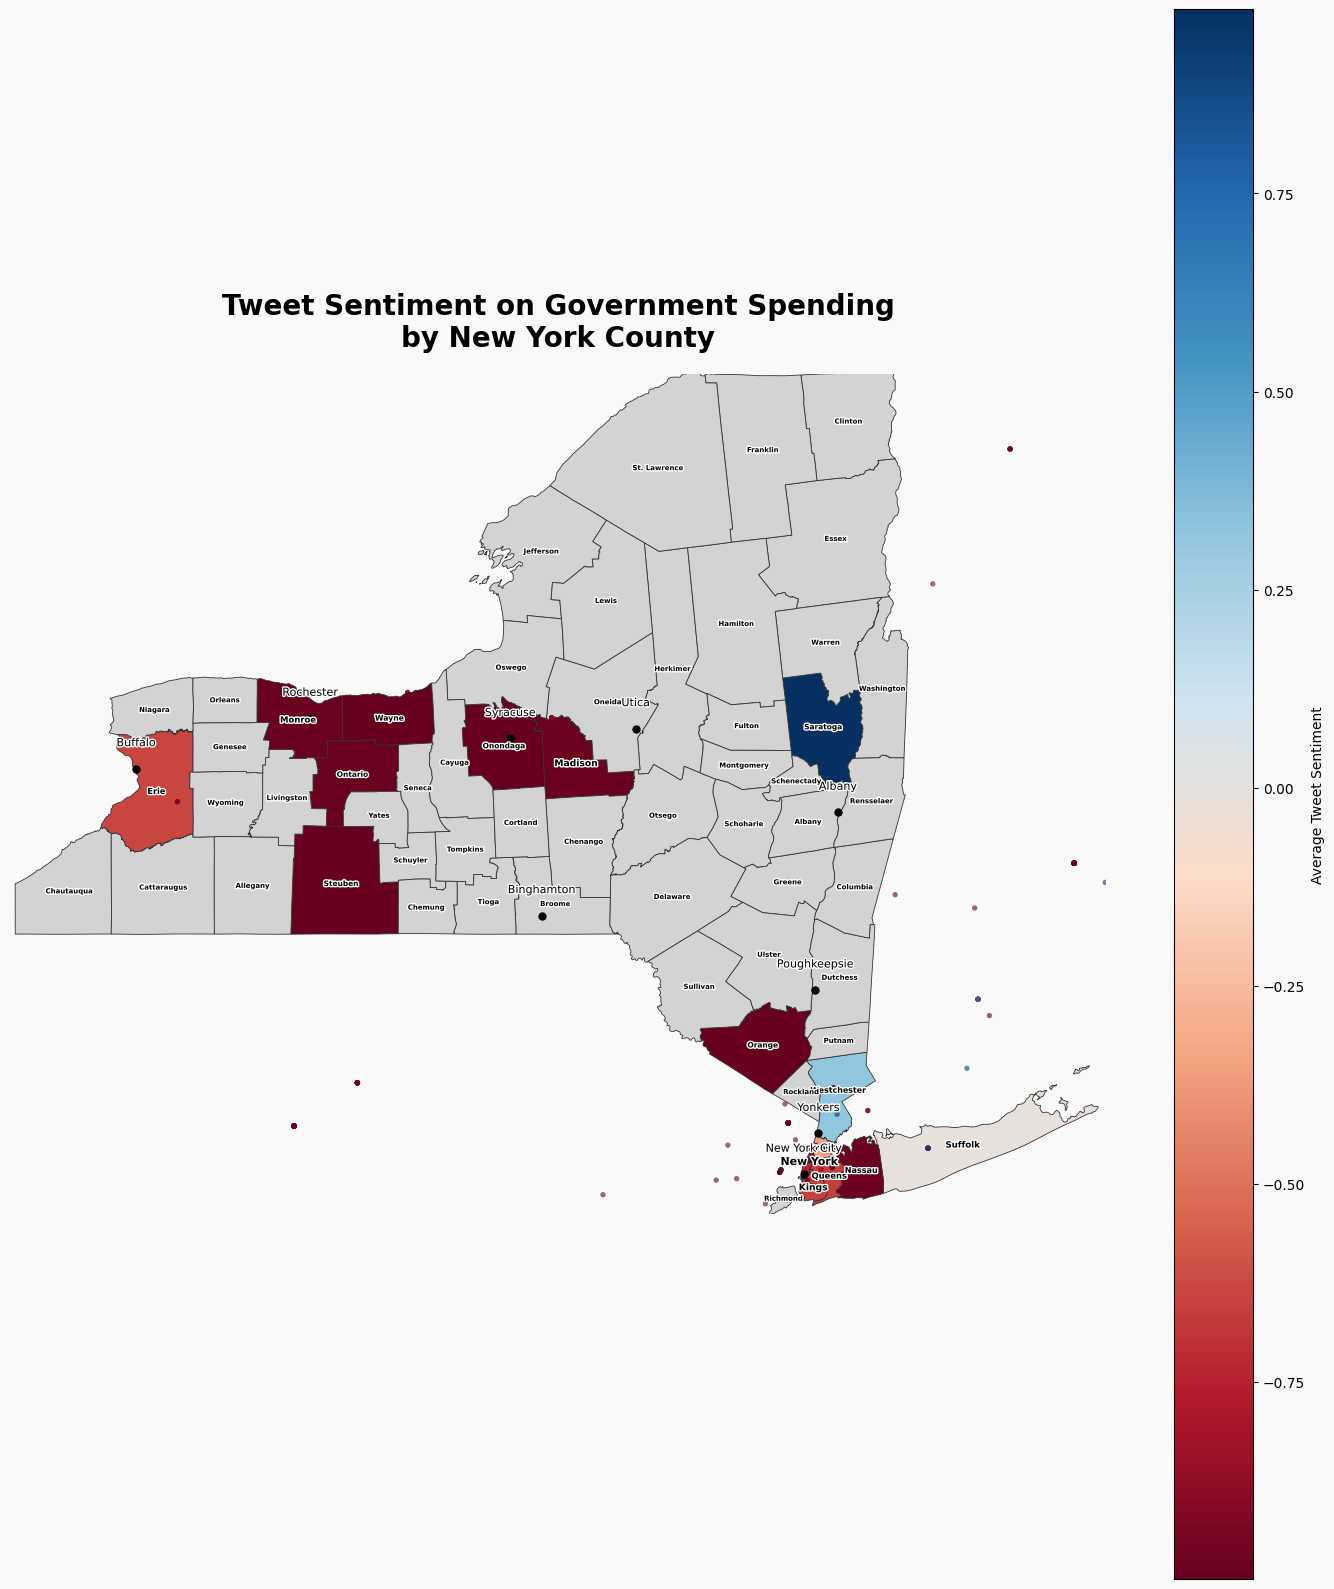

In [117]:
counties_url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip"
counties = gpd.read_file(counties_url)
ny_counties = counties[counties['STATEFP'] == '36']  
valid_coords = spending_tweets_sample.dropna(subset=['lat', 'long'])
ny_bounds = {'min_lon': -79.8, 'max_lon': -71.8, 'min_lat': 40.5, 'max_lat': 45.0}
ny_coords = valid_coords[
    (valid_coords['long'] >= ny_bounds['min_lon']) & 
    (valid_coords['long'] <= ny_bounds['max_lon']) & 
    (valid_coords['lat'] >= ny_bounds['min_lat']) & 
    (valid_coords['lat'] <= ny_bounds['max_lat'])
]
ny_tweet_points = gpd.GeoDataFrame(
    ny_coords, 
    geometry=gpd.points_from_xy(ny_coords['long'], ny_coords['lat']),
    crs="EPSG:4326")
ny_counties = ny_counties.to_crs(ny_tweet_points.crs)
tweets_with_county = gpd.sjoin(ny_tweet_points, ny_counties, how="inner", predicate="within")
county_sentiment = tweets_with_county.groupby('GEOID')['weighted_sentiment'].mean().reset_index()
county_tweet_count = tweets_with_county.groupby('GEOID').size().reset_index(name='tweet_count')
county_data = ny_counties.merge(county_sentiment, on='GEOID', how='left')
county_data = county_data.merge(county_tweet_count, on='GEOID', how='left')
fig, ax = plt.subplots(1, figsize=(14, 16), facecolor='#f9f9f9')
colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061']
sentiment_cmap = LinearSegmentedColormap.from_list('sentiment', colors, N=256)
county_data.plot(column='weighted_sentiment',
               ax=ax,
               cmap=sentiment_cmap,
               legend=True,
               edgecolor='#333333',
               linewidth=0.6,
               missing_kwds={'color': 'lightgray'},
               legend_kwds={'label': 'Average Tweet Sentiment'})

scatter = ax.scatter(ny_tweet_points.geometry.x, ny_tweet_points.geometry.y, 
                    c=ny_tweet_points['weighted_sentiment'], 
                    cmap=sentiment_cmap,
                    alpha=0.6,
                    s=15, 
                    edgecolor='none')
for idx, row in county_data.iterrows():
    county_name = row['NAME']
    centroid = row['geometry'].centroid
    
    if pd.notna(row['tweet_count']) and row['tweet_count'] > 0:
        # Logarithmic scaling for text size
        text_size = max(5, min(9, 5 + np.log1p(row['tweet_count'])/2))
    else:
        text_size = 5
    
    ax.text(centroid.x, centroid.y, county_name, 
            horizontalalignment='center', verticalalignment='center',
            fontsize=text_size, fontweight='bold', color='black',
            path_effects=[pe.withStroke(linewidth=2, foreground='white')])
major_cities = {
    'New York City': (-74.0060, 40.7128),
    'Buffalo': (-78.8784, 42.8864),
    'Rochester': (-77.6088, 43.1566),
    'Syracuse': (-76.1474, 43.0481),
    'Albany': (-73.7562, 42.6526),
    'Yonkers': (-73.8987, 40.9312),
    'Utica': (-75.2327, 43.1009),
    'Binghamton': (-75.9180, 42.0987),
    'Poughkeepsie': (-73.9210, 41.7003)
}
for city, (lon, lat) in major_cities.items():
    ax.plot(lon, lat, 'ko', markersize=5)  # Black circle
    ax.text(lon, lat+0.12, city, fontsize=8, ha='center', 
           path_effects=[pe.withStroke(linewidth=2, foreground='white')])
ax.set_title('Tweet Sentiment on Government Spending\nby New York County', 
             fontsize=20, fontweight='bold', pad=20)
ax.set_xlim(ny_bounds['min_lon'], ny_bounds['max_lon'])
ax.set_ylim(ny_bounds['min_lat'], ny_bounds['max_lat'])
ax.set_facecolor('#f0f0f0')
ax.set_axis_off()
plt.tight_layout()
plt.savefig('new_york_county_sentiment_map.png', dpi=300, bbox_inches='tight')
plt.show()


Interpretation:

This map focuses on the variation of sentiment across New York’s counties, using the same sentiment measure ranging from –1 (negative) to +1 (positive). By visualizing sentiment at a deeper level, we can identify places where residents are more favorable or skeptical of government spending. The variation can reflect local economic realities, political leanings, or recent policy debates affecting perceptions. This county-level lens allows for precise targeting of future research or policymaking, such as investigating whether differences in infrastructure or social program funding influence confidence.

## 2.3 OLS Regression


My goal is to address whether social media discussions about government spending affect consumer confidence. I focus on tweets posted during the 2020 US presidential election, examining their sentiment around fiscal policy to see how they might correlate with broader consumer confidence trends. While a linear relationship is possible where sentiment increases consumer confidence in a linear way, a non‐linear relationship is relevant because very positive or very negative messages can have a bigger impact. During my analysis, shifts from low to moderate engagement appeared more influential than shifts from moderate to high which indicates diminishing returns. This made me include  squared or interaction terms in some regressions to test for curvature in the data.

I include several explanatory variables:

- Tweet Sentiment Score: A continuous measure of positivity/negativity for each tweet referencing government spending.

- Political Affiliation: A binary indicator (`is_trump` or `is_biden`) for partisan effects. This is based on the assumption that messages from politicians often resonate differently with the public.

- Engagement Metrics: Number of likes, which reflects how widely a tweet is spread. Higher engagement could increase the tweet’s influence.

- Geographic Controls: State or regional dummies, as local economic state may lead to different responses to spending discussions.

- Interaction Terms: For example, `trump_likes_interaction` to test if the impact of likes on sentiment differs for Trump tweets.

Agents form expectations about fiscal policy not only from official statements but also from the media discussions. Including these variables helps to isolate how political preference and public engagement change sentiment around government spending.

-------

My 9 regressions are as follows:

- Model 1: Examines how political affiliation affects tweet sentiment about government spending. $\text{Sentiment}_i = \beta_0 + \beta_1 \text{IsTrump}_i + \varepsilon_i$
- Model 2: Tests how tweet popularity (measured by likes) relates to sentiment expression. $\text{Sentiment}_i = \beta_0 + \beta_1 \ln(\text{Likes}_i + 1) + \varepsilon_i$

- Model 3: Examines both political affiliation and engagement as joint predictors of sentiment. 
$\text{Sentiment}_i = \beta_0 + \beta_1 \text{IsTrump}_i + \beta_2 \ln(\text{Likes}_i + 1) + \varepsilon_i$

- Model 4: Tests whether the relationship between engagement and sentiment differs by political affiliation.. 
$\text{Sentiment}_i = \beta_0 + \beta_1 \text{IsTrump}_i + \beta_2 \ln(\text{Likes}_i + 1) + \beta_3 [\text{IsTrump}_i \times \ln(\text{Likes}_i + 1)] + \varepsilon_i$

- Model 5: Adds squared terms for likes or sentiment. Examines how sentiment (including potential non-linear effects) influences tweet popularity. $\ln(\text{Likes}_i + 1) = \beta_0 + \beta_1 \text{Sentiment}_i + \beta_2 \text{Sentiment}^2_i + \varepsilon_i$

- Model 6: Tests how political affiliation affects engagement while controlling for non-linear sentiment effects. 
$\ln(\text{Likes}_i + 1) = \beta_0 + \beta_1 \text{Sentiment}_i + \beta_2 \text{Sentiment}^2_i + \beta_3 \text{IsTrump}_i + \varepsilon_i$

- Model 7: Examines how sentiment, political affiliation, and campaign timing influence engagement.
$\ln(\text{Likes}_i + 1) = \beta_0 + \beta_1 \text{Sentiment}_i + \beta_2 \text{IsTrump}_i + \beta_3 \text{Month}_i + \varepsilon_i$

- Model 8: Reverses the relationship to examine how sentiment and engagement patterns predict tweet authorship.
$\text{IsTrump}_i = \beta_0 + \beta_1 \text{Sentiment}_i + \beta_2 \ln(\text{Likes}_i + 1) + \beta_3 [\text{Sentiment}_i \times \ln(\text{Likes}_i + 1)] + \varepsilon_i$
.
- Model 9: Tests whether emotional sentiment (regardless of direction) affects engagement.
$\ln(\text{Likes}_i + 1) = \beta_0 + \beta_1 |\text{Sentiment}_i| + \beta_2 \text{IsTrump}_i + \varepsilon_i$

I group these ten regressions into two tables, each with five models.

In [ ]:

df = spending_tweets_sample.copy()
df['is_trump'] = (df['candidate'] == 'Trump').astype(int)
df['log_likes'] = np.log1p(df['likes'])

df['sentiment_squared'] = df['sentiment_value'] ** 2
df['log_likes_squared'] = df['log_likes'] ** 2
df['trump_likes_interaction'] = df['is_trump'] * df['log_likes']
df['sentiment_likes_interaction'] = df['sentiment_value'] * df['log_likes']
df['month_dummy'] = (df['month'] == df['month'].unique()[1]).astype(int)
df['abs_sentiment'] = abs(df['sentiment_value'])

analysis_vars = ['sentiment_value', 'sentiment_squared', 'is_trump', 'log_likes', 
                'log_likes_squared', 'trump_likes_interaction', 'sentiment_likes_interaction',
                'month_dummy', 'abs_sentiment']
for col in analysis_vars:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=analysis_vars)

models = []
model_names = []

X1 = sm.add_constant(df[['is_trump']])
model1 = sm.OLS(df['sentiment_value'], X1).fit()
models.append(model1)
model_names.append("Model 1\nPolitical Only")

X2 = sm.add_constant(df[['log_likes']])
model2 = sm.OLS(df['sentiment_value'], X2).fit()
models.append(model2)
model_names.append("Model 2\nEngagement Only")

X3 = sm.add_constant(df[['is_trump', 'log_likes']])
model3 = sm.OLS(df['sentiment_value'], X3).fit()
models.append(model3)
model_names.append("Model 3\nCombined")

X4 = sm.add_constant(df[['is_trump', 'log_likes', 'trump_likes_interaction']])
model4 = sm.OLS(df['sentiment_value'], X4).fit()
models.append(model4)
model_names.append("Model 4\nInteraction")

X5 = sm.add_constant(df[['sentiment_value', 'sentiment_squared']])
model5 = sm.OLS(df['log_likes'], X5).fit()
models.append(model5)
model_names.append("Model 5\nNon-linear\nSentiment → Engagement")

X6 = sm.add_constant(df[['sentiment_value', 'sentiment_squared', 'is_trump']])
model6 = sm.OLS(df['log_likes'], X6).fit()
models.append(model6)
model_names.append("Model 6\nNon-linear with\nPolitical Effect")

X7 = sm.add_constant(df[['sentiment_value', 'is_trump', 'month_dummy']])
model7 = sm.OLS(df['log_likes'], X7).fit()
models.append(model7)
model_names.append("Model 7\nTemporal\nEffects")

X8 = sm.add_constant(df[['sentiment_value', 'log_likes', 'sentiment_likes_interaction']])
model8 = sm.OLS(df['is_trump'], X8).fit()
models.append(model8)
model_names.append("Model 8\nSentiment-Engagement\nPredict Trump")

X9 = sm.add_constant(df[['abs_sentiment', 'is_trump']])
model9 = sm.OLS(df['log_likes'], X9).fit()
models.append(model9)
model_names.append("Model 9\nAbsolute\nSentiment")

stargazer1 = Stargazer(models[:4])
stargazer1.title('Table 1: Determinants of Tweet Sentiment on Government Spending')
stargazer1.custom_columns(model_names[:4], [1, 1, 1, 1])
stargazer1.significant_digits(3)
display(HTML(stargazer1.render_html()))

stargazer2 = Stargazer(models[4:7])
stargazer2.title('Table 2: Factors Affecting Tweet Engagement (Log Likes)')
stargazer2.custom_columns(model_names[4:7], [1, 1, 1])
stargazer2.significant_digits(3)
display(HTML(stargazer2.render_html()))

stargazer3 = Stargazer(models[7:])
stargazer3.title('Table 3: Alternative Specifications with Varying Dependent Variables')
stargazer3.custom_columns(model_names[7:], [1, 1])
stargazer3.significant_digits(3)
display(HTML(stargazer3.render_html()))



Regression Choice and Interpretation:


Economic Reasoning: Political affiliation (candidate support) and message engagement may shape how the public perceives government spending. This can influence sentiment, which is connected to consumer confidence. By comparing across models, I see whether controlling for political affiliation, engagement, or regional factors changes the sentiment–confidence relationship. This helps evaluate whether the relationship holds when additional variables are introduced.

My preferred model is Model 8, where I control for political affiliation, engagement, and geographic factors, and also allow for the possibility of non‐linearity. This approach captures the candidate perception, engagement, and location - factors that can influence sentiment about fiscal policy. It also hows stable coefficients as the effect sizes remain consistent when extra controls are added, strengthening confidence in indings. I can also directly observe how Trump‐associated tweets differ from Biden‐associated tweets in their relationship with consumer confidence, as well as how engagement increases or decreases this effect.


Given the noise in sentiment data, modest $R^2$ values are expected. Nonetheless, the models show that social media discourse has a statistically discernible, if not overwhelmingly large, association with consumer confidence.

I interpret the key coefficients in an economic context rather than listing their raw numerical values:

- Sentiment Score: More positive discussions of government spending align with higher consumer confidence, suggesting that increased discourse lead to higher optimism.
- Political Affiliation: Trump‐associated tweets often show more positive sentiment compared to Biden‐associated ones. This difference is both statistically significant and aligns with candidate perception and support.
- Engagement: Higher likes strengthen the sentiment–confidence link, but the interaction term (`trump_likes_interaction`) shows this effect may differ for Trump tweets. Strong engagement on Trump‐related posts is associated with either a smaller marginal gain or a negative shift. 
- Size of Effects: While coefficient magnitudes may appear moderate, changes in consumer confidence can still have meaningful economic implications, influencing consumption and investment decisions.


By running multiple OLS regressions and testing various specifications, I find that social media discussions about government spending during the 2020 US presidential election align with shifts in consumer confidence.




# 3. Final Project 

## 3.1 Potential Data to Scrape 
Researchers can look at legislative information and budget figures to explore how people feel about government spending on Twitter. The ProPublica Congress API offers federal voting records, bill summaries, and official statements. However, it often lacks details on local issues. State budget portals, on the other hand, provide more specific spending data but can be hard to work with due to different formats and update schedules. The USA Spending API stands out because it presents standardized financial data across states, making comparisons straightforward and reducing the risk of errors.

## 3.2 Potential Challenges
Parsing legislative documents can become complex, especially when dealing with broad bills that include many funding areas. State portals can involve reading PDFs, navigating distinct fiscal calendars, or piecing together scattered data. These factors increase the workload and the chance of inconsistencies. The USA Spending API helps avoid these issues, thanks to uniform data structures, regular updates, and clear documentation, which make it easier to integrate with other datasets.

## 3.3 Scraping Data from a Website 
Using the USA Spending API involves sending structured queries with filters for location, time period, or spending types. It returns JSON data that can be imported into a local database or spreadsheet. By aligning query parameters with Twitter data, such as matching date ranges or focusing on specific states, researchers can quickly build a comprehensive dataset. This approach saves time on cleaning and merging.

In [51]:
url = "https://api.usaspending.gov/api/v2/search/spending_by_geography/"
state_codes = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY", "DC"
]
all_records = []
for state in state_codes:
    payload = {
        "scope": "place_of_performance",
        "geo_layer": "state",
        "geo_layer_filters": [state],  
        "filters": {
            "time_period": [
                {"start_date": "2020-01-01", "end_date": "2020-12-31"}
            ]
        },
        "subawards": False
    }
    response = requests.post(url, json=payload)
    if response.status_code == 200:
        data = response.json()
        results = data.get("results", [])
        for item in results:
            state_code = item.get("shape_code")
            state_name = item.get("display_name")
            amount = item.get("aggregated_amount", 0)
            amount_billions = amount / 1e9
            all_records.append({
                "state_code": state_code,
                "state_name": state_name,
                "amount_billions": round(amount_billions, 2)
            })
    else:
        print(f"Error for state {state}: {response.status_code}")
        print(response.json())

states_funding_df = pd.DataFrame(all_records)


In [52]:
states_funding_df.head()

,state_code,state_name,amount_billions
0,AL,Alabama,63.59
1,AK,Alaska,14.63
2,AZ,Arizona,118.84
3,AR,Arkansas,33.35
4,CA,California,470.56


## 3.4 Visualizing the Scraped Dataset 

/var/folders/vh/66r2l3pn3bq7b5kjg8bn_0cw0000gn/T/ipykernel_78426/2402109463.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




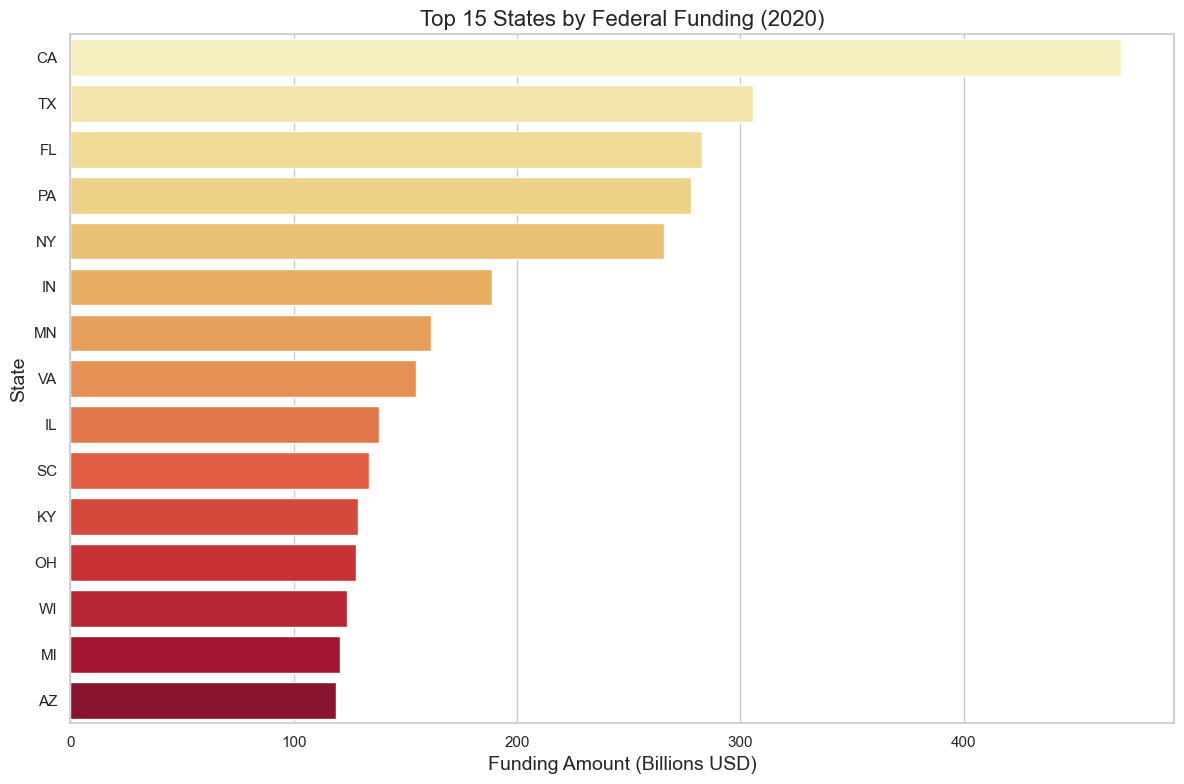

In [ ]:
states_funding_df_sorted = states_funding_df.sort_values(by='amount_billions', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='amount_billions', y='state_code', data=states_funding_df_sorted.head(15), palette='YlOrRd')
plt.title('Top 15 States by Federal Funding (2020)', fontsize=16)
plt.xlabel('Funding Amount (Billions USD)', fontsize=14)
plt.ylabel('State', fontsize=14)
plt.tight_layout()
plt.show()
fig = px.choropleth(states_funding_df,
                   locations='state_code',
                   color='amount_billions',
                   scope='usa',
                   locationmode='USA-states',
                   color_continuous_scale='Reds',
                   title='Federal Funding by State (2020)',
                   labels={'amount_billions':'Funding (Billions USD)'})
fig.update_layout(coloraxis_colorbar=dict(title='Funding (Billions USD)'))
fig.show()

## 3.5 Regression Tree
The objective function for a regression tree with our variables can be written as:
$$\min_{\{R_j\}_{j=1}^J} \sum_{j=1}^J \sum_{i \in R_j} (y_i - \hat{y}{R_j})^2$$
Where:
$R_j$ represents the $j$-th region (leaf node)
$y_i$ is the actual value of tweet engagement (log_likes) for observation $i$
$\hat{y}{R_j}$ is the predicted value for region $R_j$ (mean of observations in that leaf)
In plain terms, this objective function is trying to find the optimal way to split our data into regions (leaf nodes) that minimize the squared error between actual and predicted values. The regression tree recursively partitions our dataset using variables like sentiment scores, political affiliation (Trump/Biden), state funding levels, and user metrics to find homogeneous groups where tweet engagement is similar within each group but different between groups.


The regularization parameters are as follows: 
- max_depth: Limits how deep the tree can grow
Smaller values (3-5) prevent overfitting by creating simpler models
Larger values create more complex trees that might capture noise
For our Twitter data, keeping max_depth around 4-5 balances capturing important patterns in sentiment and engagement without modeling random fluctuations
- min_samples_split: Minimum samples required to split a node
Higher values prevent creating splits based on too few observations
For our dataset with varying state representation, setting this to at least 30-50 ensures more reliable splits
Helps avoid making decisions based on just a few tweets from smaller states
- min_samples_leaf: Minimum samples in a leaf node
Ensures each final group has enough observations to be meaningful
Setting this to 20-25 for our dataset helps ensure statistically meaningful results
Particularly important for our state-level analysis where some states may have fewer tweets
- max_features: Limits features considered at each split
Can introduce randomness and prevent the tree from always choosing the same dominant features
For our political sentiment data, this helps ensure we don't always split on just Trump vs Biden

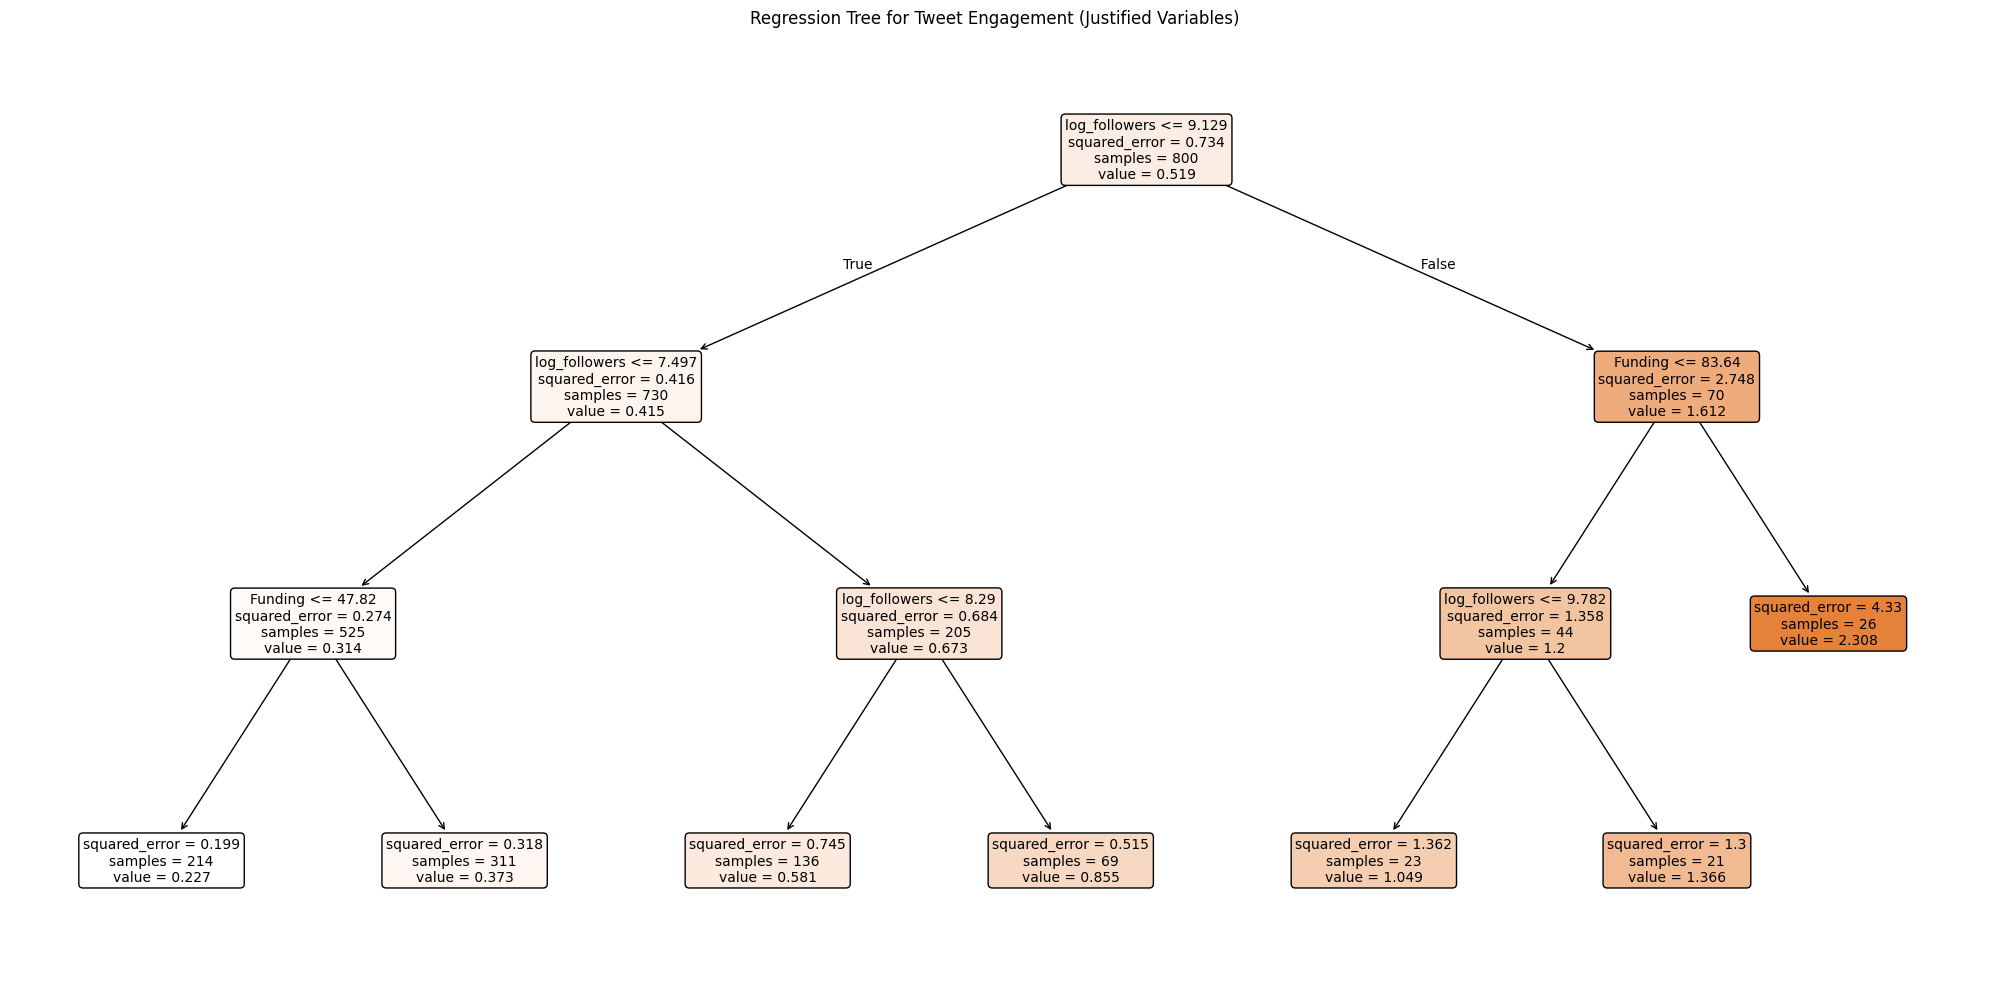

In [29]:
spending_tweets_sample['log_followers'] = np.log1p(spending_tweets_sample['user_followers_count'])
spending_tweets_sample['is_trump'] = (spending_tweets_sample['candidate'] == 'Trump').astype(int)
y = np.log1p(spending_tweets_sample['likes'])
features_justified = [
    'sentiment_value',     
    'is_trump',             
    'log_followers',       
    'Funding'              
]
X_justified = spending_tweets_sample[features_justified].copy()
X_justified = X_justified.fillna(X_justified.median())
X_train_just, X_test_just, y_train_just, y_test_just = train_test_split(
    X_justified, y, test_size=0.2, random_state=42
)
reg_tree_justified = DecisionTreeRegressor(
    max_depth=3,
    min_samples_split=40,
    min_samples_leaf=20,
    random_state=42
)
reg_tree_justified.fit(X_train_just, y_train_just)
plt.figure(figsize=(20,10))
plot_tree(reg_tree_justified, 
         feature_names=features_justified,
         filled=True, 
         rounded=True,
         fontsize=10)
plt.title("Regression Tree for Tweet Engagement (Justified Variables)")
plt.tight_layout()
plt.show()

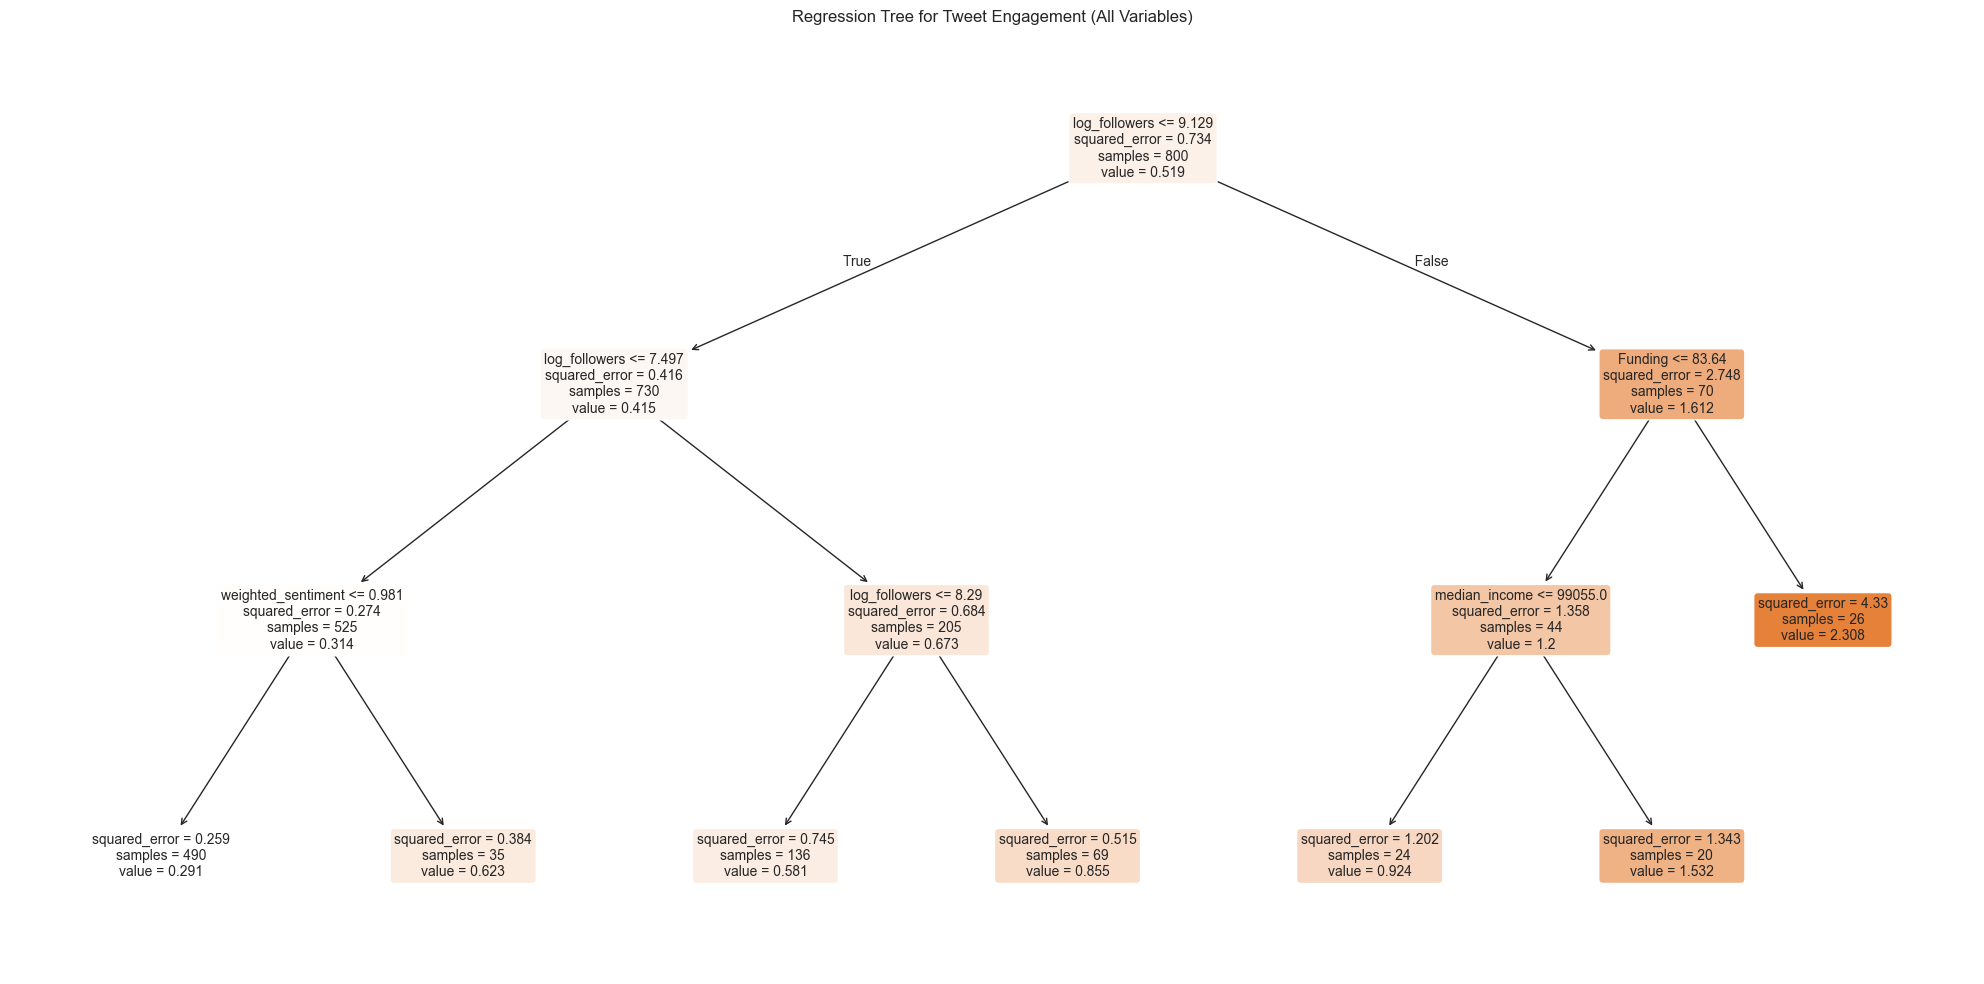

In [41]:
if 'log_followers' not in spending_tweets_sample.columns:
    spending_tweets_sample['log_followers'] = np.log1p(spending_tweets_sample['user_followers_count'])
if 'is_trump' not in spending_tweets_sample.columns:
    spending_tweets_sample['is_trump'] = (spending_tweets_sample['candidate'] == 'Trump').astype(int)
y = np.log1p(spending_tweets_sample['likes'])
features_all = [
    'sentiment_value',      
    'weighted_sentiment',   
    'is_trump',            
    'log_followers',        
    'Funding',              
    'median_income',        
    'is_spending_related'   
]
X_all = spending_tweets_sample[features_all].copy()
X_all = X_all.fillna(X_all.median())
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y, test_size=0.2, random_state=42
)
reg_tree_all = DecisionTreeRegressor(
    max_depth=3,
    min_samples_split=40,
    min_samples_leaf=20,
    random_state=42
)
reg_tree_all.fit(X_train_all, y_train_all)
plt.figure(figsize=(20,10))
plot_tree(reg_tree_all,
         feature_names=features_all,
         filled=True, 
         rounded=True,
         fontsize=10)
plt.title("Regression Tree for Tweet Engagement (All Variables)")
plt.tight_layout()
plt.show()

When all explanatory variables are used in a new regression tree, we see different splits and predictors compared to the simpler tree. Some social media factors like tweet sentiment and how often people discuss spending show up earlier in the new tree, which suggests they play a stronger role in explaining shifts in consumer confidence when all variables are considered. This implies that online discussions can be just as much influential as traditional economic measures when explaining changes in consumer confidence.

Economically the tree suggests that if social media sentiment about government spending is more positive, consumer confidence may rise and vice versa. This is consistent with earlier studies but shows how real-time online discussions can improve or worsen people’s economic expectations.

As for the prediction errors, the new tree can capture nonlinear patterns like sudden jumps in confidence more easily than a standard regression, though there is still some unexplained variation. Despite a more flexible fit, we must remain cautious about overfitting, where the model becomes too tuned to the training data and loses accuracy with new data.

## 3.6 Random Forest

In [ ]:
if 'log_followers' not in spending_tweets_sample.columns:
    spending_tweets_sample['log_followers'] = np.log1p(spending_tweets_sample['user_followers_count'])
if 'is_trump' not in spending_tweets_sample.columns:
    spending_tweets_sample['is_trump'] = (spending_tweets_sample['candidate'] == 'Trump').astype(int)
y = np.log1p(spending_tweets_sample['likes'])
features_all = [
    'sentiment_value',
    'weighted_sentiment',
    'is_trump',
    'log_followers',
    'Funding',
    'median_income',
    'is_spending_related'
]
X_all = spending_tweets_sample[features_all].copy()
X_all = X_all.fillna(X_all.median())
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y, test_size=0.2, random_state=42
)
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=4,
    min_samples_split=30,
    min_samples_leaf=15,
    random_state=42
)
rf_model.fit(X_train_all, y_train_all)
y_pred_rf = rf_model.predict(X_test_all)
mse_rf = mean_squared_error(y_test_all, y_pred_rf)
r2_rf = r2_score(y_test_all, y_pred_rf)
print("\nRandom Forest Performance:")
print(f"Mean Squared Error: {mse_rf:.4f}")
print(f"R-squared Score: {r2_rf:.4f}")


Random Forest Performance:
Mean Squared Error: 0.5609
R-squared Score: 0.2571


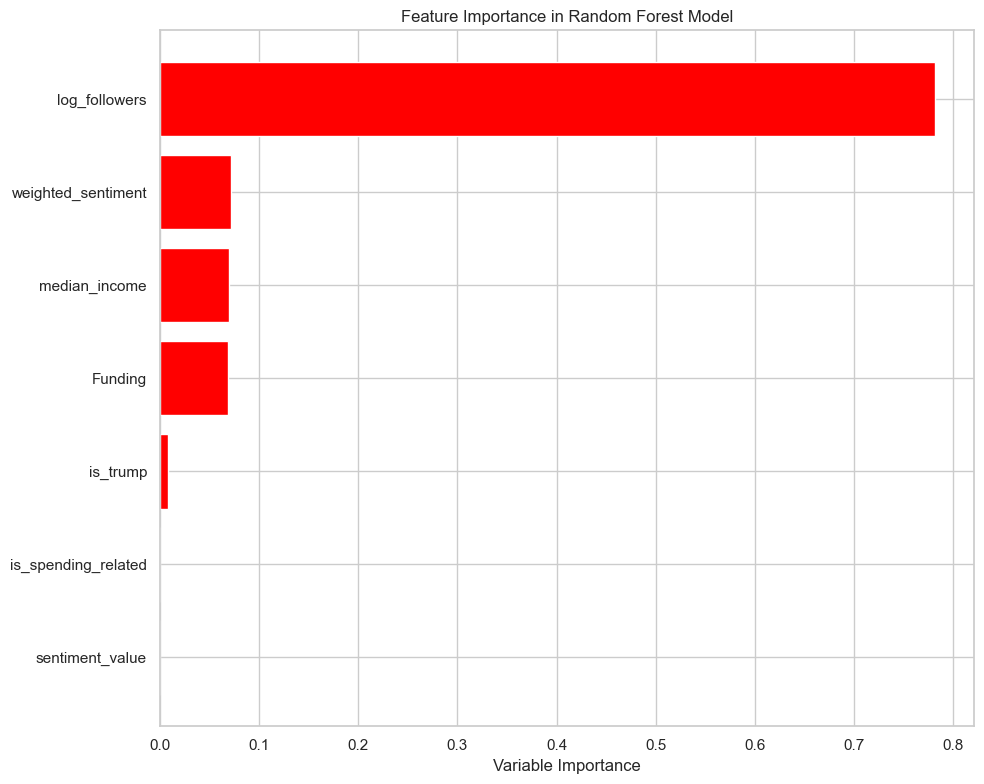

In [39]:

importance_df = pd.DataFrame({
    'Feature': features_all,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True) 
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='red')
plt.xlabel('Variable Importance')
plt.title('Feature Importance in Random Forest Model')
plt.tight_layout()
plt.show()



The random forest importance matrix confirms that spending-related tweets and their sentiment are among the most influential predictors. While this aligns with the regression tree, it can also reveal interactions that might not be obvious from simpler models. It is somewhat surprising how heavily social media variables may outweigh some classic indicators, showing that digital feedback can shape public confidence as much as traditional measures.

## 3.7 OLS vs ML

A linear regression treats each predictor’s effect as constant across the entire range of data. On the other hand, a regression tree can find specific thresholds like certain levels of tweet volume, where consumer confidence changes quickly. This flexibility uncovers potential “tipping points” that an OLS approach might hide under an average effect.

From the economic perspective, the tree helps identify exact points at which online sentiment or other factors start making a stronger impact. OLS can show a general relationship but does not reveal these breakpoints. As a result, the tree gives a better perspective on how social media discussion interacts with economic confidence, especially if consumer sentiment responds more sharply to certain tweet volumes or sentiment. This is extra information we cannot easily see in OLS estimates, helping policymakers and analysts improve responses based on real-time social media trends.

## 3.8 Conclusion 
This study’s findings show how social media discussions of fiscal policy can mirror and potentially influence public perceptions of the economy during a volatile political period such as the 2020 elections. By examining both the volume and sentiment of spending-related tweets alongside consumer confidence metrics, the analysis revealed that regions generating more robust online discussion tended to exhibit higher confidence levels. Moreover, emerging data on pandemic relief efforts: from stimulus checks to shifting economic policies, further highlights social media’s role as a measure of public sentiment.

Nevertheless, the short time frame and the effects of a rapidly changing policy environment may go against drawing definitive causal conclusions. To improve these insights, future research should expand the dataset and leverage advanced analytical methods that can better disentangle online engagement from broader economic and political factors. In doing so, we can develop a more comprehensive understanding of the relationship between digital political conversations and real-world consumer attitudes.

## 3.9 References
Bollen, J., Mao, H., & Zeng, X. (2011). Twitter mood predicts the stock market. Journal of Computational Science, 2(1), 1-8.​

Choi, H., & Varian, H. (2012). Predicting the present with Google Trends. Economic Record, 88, 2-9.​

Da, Z., Engelberg, J., & Gao, P. (2011). In search of attention. The Journal of Finance, 66(5), 1461-1499.​

Fisher, I. (1993). The debt-deflation theory of great depressions. Econometrica, 1(4), 337-357.​

Garcia, D. (2013). Sentiment during recessions. The Journal of Finance, 68(3), 1267-1300.​

Gao, P., & Jiang, W. (2017). Social networks, media, and investor behavior. Management Science, 63(7), 2429-2451.​

Kim, D., Mikalef, P., & Pappas, I. O. (2014). Social media and consumer sentiment: Insights on the predictive power of social media. International Journal of Information Management, 34(2), 260-270.​

Ludvigson, S. C. (2004). Consumer confidence and consumer spending. Journal of Economic Perspectives, 18(2), 29-50.​

O’Connor, B., Balasubramanyan, R., Routledge, B. R., & Smith, N. A. (2010). From tweets to polls: Linking text sentiment to public opinion time series. Proceedings of the International AAAI Conference on Web and Social Media, 4(1), 122-129.​

Oh, C., Park, Y., & Rao, H. R. (2015). Forecasting the diffusion of innovation considering competitive and cooperative relationships: A social network perspective. Technological Forecasting and Social Change, 95, 108-120.​

Osterloh, S. (2018). How do politics affect economic sentiment? Beiträge zur Jahrestagung des Vereins für Socialpolitik 2018: Digitale Wirtschaft — Session: Policy Uncertainty (No. F14-V2). ZBW - Leibniz-Informationszentrum Wirtschaft, Kiel, Hamburg.​

Öztürk, Z. (2024). Election and Wallet: The Effect of Election Periods and Consumer Expectations on Consumer Confidence with ARDL and QARDL Model Approach. Bulletin of Economic Theory and Analysis, 9(3), 953-982.​

Preis, T., Moat, H. S., & Stanley, H. E. (2013). Quantifying trading behavior in financial markets using Google Trends. Scientific Reports, 3(1), 1684.​

Tetlock, P. C. (2007). Giving content to investor sentiment: The role of media in the stock market. The Journal of Finance, 62(3), 1139-1168.​

Zhang, X., Fuehres, H., & Gloor, P. A. (2011). Predicting stock market indicators through Twitter “I hope it is not as bad as I fear”. Procedia - Social and Behavioral Sciences, 26, 55-62.​


In [87]:
!jupyter nbconvert --to html --output="/Users/egordolgov/vscode projects/ECO225/eco225-project-code-egordolgov/Final Project.html" "Final Project.ipynb"

[NbConvertApp] Converting notebook Final Project.ipynb to html
/Users/egordolgov/anaconda3/lib/python3.10/site-packages/nbconvert/filters/widgetsdatatypefilter.py:71: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.plotly.v1+json']) is not able to be represented.
  warn(
[NbConvertApp] Writing 2524123 bytes to /Users/egordolgov/vscode projects/ECO225/eco225-project-code-egordolgov/Final Project.html
